# Контроль температуры сплава

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. 

**Задача**  — построить модель, которая будет предсказывать температуру сплава. Заказчик хочет использовать разработанную модель для имитации технологического процесса.

**Описание данных**

Данные хранятся в Sqlite. Она состоит из нескольких таблиц:
- `steel.data_arc` — данные об электродах;
- `steel.data_bulk` — данные об объёме сыпучих материалов;
- `steel.data_bulk_time` — данные о времени подачи сыпучих материалов;
- `steel.data_gas` — данные о продувке сплава газом;
- `steel.data_temp` — данные об измерениях температуры;
- `steel.data_wire` — данные об объёме проволочных материалов;
- `steel.data_wire_time` — данные о времени подачи проволочных материалов.

Таблица `steel.data_arc`
- `key` — номер партии;
- `BeginHeat` — время начала нагрева;
- `EndHeat` — время окончания нагрева;
- `ActivePower` — значение активной мощности;
- `ReactivePower` — значение реактивной мощности.

Таблица `steel.data_bulk`
- `key` — номер партии;
- `Bulk1 … Bulk15` — объём подаваемого материала.

Таблица `steel.data_bulk_time`
- `key` — номер партии;
- `Bulk1 … Bulk15` — время подачи материала.

Таблица `steel.data_gas`
- `key` — номер партии;
- `gas` — объём подаваемого газа.

Таблица `steel.data_temp`
- `key` — номер партии;
- `MesaureTime` — время замера;
- `Temperature` — значение температуры.

Таблица `steel.data_wire`
- `key` — номер партии;
- `Wire1 … Wire9` — объём подаваемых проволочных материалов.

Таблица `steel.data_wire_time`
- `key` — номер партии;
- `Wire1 … Wire9` — время подачи проволочных материалов.

Во всех файлах столбец `key` содержит номер партии. В таблицах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

**Метрика** MAE < 6.8

**План исследования** 
1. Изучение данных
2. Исследовательский анализ данных и предобработка данных
3. Объединение таблиц
4. Исследовательский анализ итоговой таблицы
5. Корреляционный анализ
6. Обучение моеделей
7. Вывод

# Изучение данных

## Импорт библиотек

In [ ]:
!pip install pandas==2.1.4 scikit-learn==1.3.0 numpy==1.24.3 
!pip install SQLAlchemy==1.4.39 scipy==1.10.1 seaborn==0.13.2 torch==2.5.0
!pip install matplotlib==3.7.1 lightgbm==4.4.0 phik==0.12.4

In [2]:
import os
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import normaltest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    train_test_split, cross_val_score, KFold, GridSearchCV)
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import torch
import torch.nn as nn
from tqdm.notebook import tqdm

from sqlalchemy import (
    create_engine, MetaData, Table, inspect)
from sqlalchemy.orm import sessionmaker

import phik
from phik.report import plot_correlation_matrix

from lightgbm import LGBMRegressor

In [3]:
%matplotlib inline
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

In [4]:
warnings.simplefilter('ignore', UserWarning)

## Функции

In [6]:
def count_prop_na(data):
    '''
    Функция считает количество пропусков в датафрейме, 
    а также их долю относительно всех значений. Создает 
    датафрейм с двумя столбцами. Первый - Пропуск, второй -
    Доля
    args:
        data (DataFrame): датафрейм, в котором нужно посчитать
        пропуски
    returns:
        data (DataFrame): итоговый датафрейм
    '''
    count_na = pd.Series(data.isna().sum(), name='Пропуск')
    proportion_na = pd.Series(
        (data.isna().sum() / len(data)) * 100, name='Доля')
    return pd.concat([count_na, proportion_na], axis=1).sort_values(
        by='Доля', ascending=False)

In [7]:
def test_normal(data, alpha):
    '''
    Функция проверяет данные на нормальное
    распределени, используя тест Д’Агостино. 
    Принимает столбец и сверяет его p-value с уровнем 
    статистической значимости, выводит ответ о нормальности
    args:
        data (DataFrame): столбец датафрейма 
        alpha (float): уровень значимости
    '''

    stat, p = normaltest(data)
    
    if p > alpha:
        print('Не отвергаем H0. Данные получены из нормального распределения')
    else:
        print('Отвегаем H0 и принимаем H1. \
Данные не получены из нормального распределения')

## Константы

In [8]:
PATH_TO_DB = 'ds-plus-final.db'
RANDOM_STATE = 111124
ALPHA = 0.05
TEST_SIZE = 0.25

## Загрузка данных

In [9]:
# Подключаемся к базе данных
engine = create_engine(f'sqlite:///{PATH_TO_DB}', echo=False) 

In [10]:
metadata = MetaData()  # Создаем объект

Посмотрим какие у нас есть таблицы

In [11]:
# Загружаем метаданные из базы данных и выводим названия всех таблиц
metadata.reflect(bind=engine)

for table in metadata.tables:
    print(table)

contract
data_arc
data_bulk
data_bulk_time
data_gas
data_temp
data_wire
data_wire_time
internet
personal
phone


Есть таблицы, которые не были описаны в документации. Это `contract`, `internet`, `personal` и `phone`. Судя по названию таблиц они ни как не связаны с температурой, которую необходимо предсказать по условию задачи, поэтому эти таблицы и не были описаны.

Теперь узнаем все ли таблицы имеют набор данных. Для этого необходимо создать сессию.

In [12]:
Session = sessionmaker(bind=engine) # Объявляем сессию

In [13]:
session = Session () # Создаем объект

In [14]:
# Создаем цикл для подсчета записей во всех таблицах
for table_name, table in metadata.tables.items():
    count = session.query(table).count()
    if count == 0:
        print(f'Таблица {table_name} не содержит набор данных.')
    else:
        print(f'Таблица {table_name} содержит {count} записей.')

Таблица contract содержит 7043 записей.
Таблица data_arc содержит 14876 записей.
Таблица data_bulk содержит 3129 записей.
Таблица data_bulk_time содержит 3129 записей.
Таблица data_gas содержит 3239 записей.
Таблица data_temp содержит 18092 записей.
Таблица data_wire содержит 3081 записей.
Таблица data_wire_time содержит 3081 записей.
Таблица internet содержит 5517 записей.
Таблица personal содержит 7043 записей.
Таблица phone содержит 6361 записей.


In [15]:
session.close() # Закрываем сессию

Все таблицы содержат данные.

## Вывод

Загрузили БД. Выяснили, что она содержит больше таблиц, чем описано в документации. Исходя из названий не описанных таблиц сделали вывод, что они никак не помогут с решением задачи и больше связаны с другой задачей. Также все таблицы содержат записи.

- Таблица data_arc содержит 14876 записей.
- Таблица data_bulk содержит 3129 записей.
- Таблица data_bulk_time содержит 3129 записей.
- Таблица data_gas содержит 3239 записей.
- Таблица data_temp содержит 18092 записей.
- Таблица data_wire содержит 3081 записей.
- Таблица data_wire_time содержит 3081 записей.

# Исследовательский анализ данных и предобработка данных

Проведем анализ для каждой из таблицы. Проверим наличие пропусков, аномалий. А также изучим распределение признаков.

## steel.data_arc

In [16]:
# Пишем sql-запрос
query = '''
SELECT *
FROM data_arc
'''

In [17]:
# Записываем результат запроса в датафрейм
data_arc = pd.read_sql_query(query, con=engine)

In [18]:
data_arc.head() # Смотрим первые 5 строк

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [19]:
data_arc.info() # Смотрим информацию о df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


Можно отметить, что количество строк в таблице совпадает, что говорит о том, что нет пропусков. Также стоит поменять тип данных в двух столбцах с `object` на `datetime`

In [20]:
# Меняем тип данных
data_arc['Начало нагрева дугой'] = pd.to_datetime(
    data_arc['Начало нагрева дугой'], format='%Y-%m-%d %H:%M:%S')

In [21]:
# Меняем тип данных
data_arc['Конец нагрева дугой'] = pd.to_datetime(
    data_arc['Конец нагрева дугой'], format='%Y-%m-%d %H:%M:%S')

In [22]:
data_arc.dtypes # Проверяем тип данных

key                              int64
Начало нагрева дугой    datetime64[ns]
Конец нагрева дугой     datetime64[ns]
Активная мощность              float64
Реактивная мощность            float64
dtype: object

Проверим данные на пропуски и дубликаты. Для подсчета пропусков была написана функция `count_prop_na`, которая принимает датафрейм и считаем количество пропусков в нем и их долю от общего числа.

In [23]:
# Вызываем функцию для подсчета пропусков
count_prop_na(data_arc)

,Пропуск,Доля
key,0,0.0
Начало нагрева дугой,0,0.0
Конец нагрева дугой,0,0.0
Активная мощность,0,0.0
Реактивная мощность,0,0.0


In [24]:
data_arc.duplicated().sum() # Считаем дубликаты

0

Пропусков и дубликатов в данных нет. Перейдем к изучению выбросов и распределнию данных

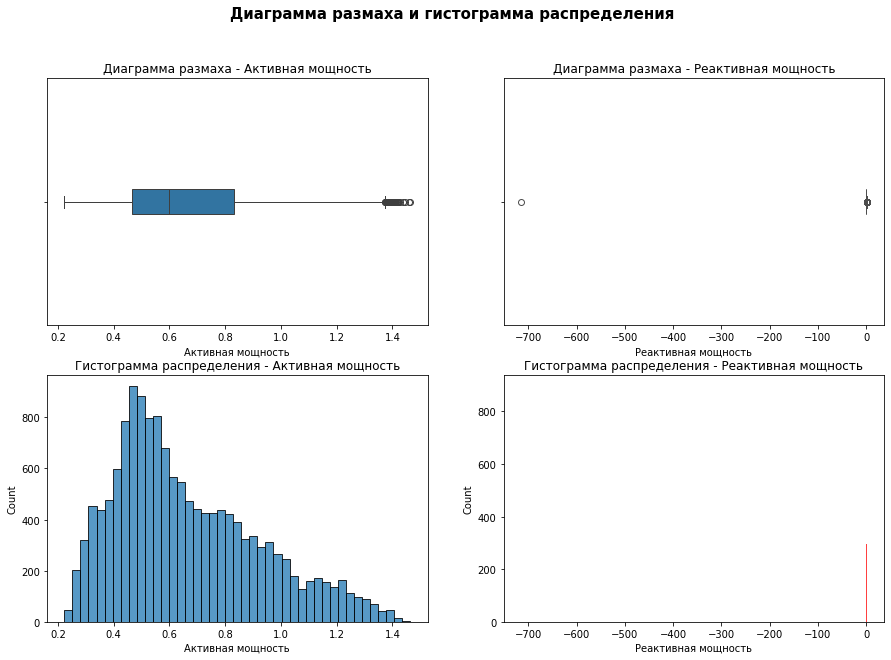

In [25]:
plt.figure(figsize=(15, 10))

plt.suptitle('Диаграмма размаха и гистограмма распределения',
             fontsize=15, fontweight='bold')

plt.subplot(2, 2, 1)
sns.boxplot(x=data_arc['Активная мощность'], width=.1)
plt.title('Диаграмма размаха - Активная мощность')

plt.subplot(2, 2, 2)
sns.boxplot(x=data_arc['Реактивная мощность'], width=.1, color='red')
plt.title('Диаграмма размаха - Реактивная мощность')

plt.subplot(2, 2, 3)
sns.histplot(data=data_arc, x='Активная мощность')
plt.title('Гистограмма распределения - Активная мощность')

plt.subplot(2, 2, 4)
sns.histplot(data=data_arc, x='Реактивная мощность', color='red')
plt.title('Гистограмма распределения - Реактивная мощность')

plt.show()

По реактивной мощности видно аномальное значение. Так как такое значение всего одно, то удалим его.

In [26]:
data_arc[data_arc['Реактивная мощность'] < 0]  # Смотрим на аномальное значение

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


In [27]:
# Удаляем аномальное значение
data_arc = data_arc[data_arc['Реактивная мощность'] > 0]

Теперь еще раз построим графики

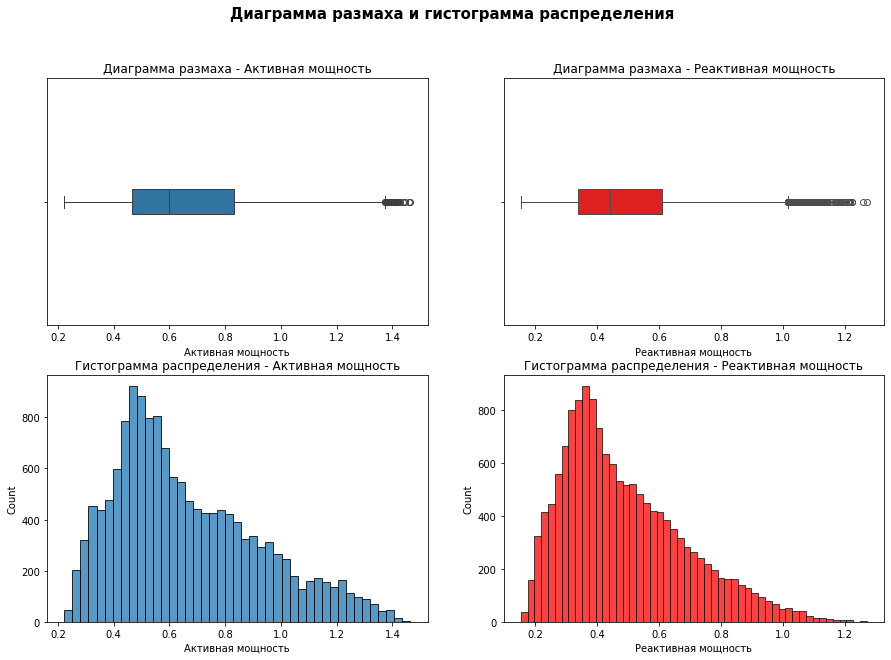

In [28]:
plt.figure(figsize=(15, 10))

plt.suptitle('Диаграмма размаха и гистограмма распределения',
             fontsize=15, fontweight='bold')

plt.subplot(2, 2, 1)
sns.boxplot(x=data_arc['Активная мощность'], width=.1)
plt.title('Диаграмма размаха - Активная мощность')

plt.subplot(2, 2, 2)
sns.boxplot(x=data_arc['Реактивная мощность'], width=.1, color='red')
plt.title('Диаграмма размаха - Реактивная мощность')

plt.subplot(2, 2, 3)
sns.histplot(data=data_arc, x='Активная мощность')
plt.title('Гистограмма распределения - Активная мощность')

plt.subplot(2, 2, 4)
sns.histplot(data=data_arc, x='Реактивная мощность', color='red')
plt.title('Гистограмма распределения - Реактивная мощность')

plt.show()

Перед тем, как анализировать графики на наличие выбросов. Посмотрим на распределение, вдруг можно воспользоваться Z-тестом или тестом Граббса. По графикам видно, что данные не имеют нормального распределения, но чтобы убедится в этом, воспользуемся статистическим тестом `Д’Агостино`, так как у нас наблюдений > 5000, для этого была написана функция `test_normal`. Перед этим сформулируем гипотезы:
- **H0** - Данные получены из нормального распределения
- **H1** - Данные не получены из нормального распределения

Предположим, что верна **H0**, тогда:

In [29]:
test_normal(data_arc['Активная мощность'], ALPHA)

Отвегаем H0 и принимаем H1. Данные не получены из нормального распределения


In [30]:
test_normal(data_arc['Реактивная мощность'], ALPHA)

Отвегаем H0 и принимаем H1. Данные не получены из нормального распределения


Статистический тест подтвердил наше наблюдение, что данные не имеют нормального распределения, а поэтому для поиска выбросов и аномалий мы не можем воспользоваться Z-тестом и тестом Граббаса. Будем ориентироваться на `boxplot`. В целом хоть на графиках и показаны выбивающиеся значения, но аномальными их считать не будем, так как в целом такие значения могут быть и они не сильно выделяются он основного набора данных.

### Генерация признаков

Попробуем сгенерировать новые признаки: длительность нагрева, общую мощность, соотношение активной мощности к реактивной, количество запуска нагрева электродами.

In [31]:
# Считаем общую мощность по каждому нагреву в каждой партии
data_arc['Общая мощность'] = data_arc['Активная мощность'] + \
    data_arc['Реактивная мощность']

In [32]:
# Считаем соотношение мощностей по каждому нагреву в каждой партии
data_arc['Активная/Реактивная'] = data_arc['Активная мощность'] / \
    data_arc['Реактивная мощность']

In [33]:
# Считаем длительность каждого нагрева
data_arc['Длительность нагрева'] = data_arc['Конец нагрева дугой'] - \
    data_arc['Начало нагрева дугой']

In [34]:
# Считаем общую мощность в партии
data_arc['Общая мощность'] = data_arc.groupby(
    'key')['Общая мощность'].transform('sum')

In [35]:
# Считаем общую длительность нагрева в партии
data_arc['Длительность нагрева'] = data_arc.groupby(
    'key')['Длительность нагрева'].transform('sum')

In [36]:
# Считаем сколько всего было нагревов в партии
data_arc['Количество нагревов'] = data_arc.groupby(
    'key')['key'].transform('count')

У каждой партии в итоговом датафрейме должно быть одно наблюдение, поэтому необходимо также посчитать общую реактивную и активную мощность.

In [37]:
# Считаем общую активную мощность 
data_arc['Активная мощность'] = data_arc.groupby('key')['Активная мощность'].transform('sum')

In [38]:
# Считаем общую реактивную мощность 
data_arc['Реактивная мощность'] = data_arc.groupby('key')['Реактивная мощность'].transform('sum')

In [39]:
# Считаем отношение общей активной к общей реактивной 
data_arc['Активная/Реактивная'] = data_arc['Активная мощность'] / data_arc['Реактивная мощность']

In [40]:
data_arc.head()  # Смотрим результат

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Общая мощность,Активная/Реактивная,Длительность нагрева,Количество нагревов
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,3.03673,2.142821,5.179551,1.417165,0 days 00:18:18,5
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,3.03673,2.142821,5.179551,1.417165,0 days 00:18:18,5
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,3.03673,2.142821,5.179551,1.417165,0 days 00:18:18,5
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,3.03673,2.142821,5.179551,1.417165,0 days 00:18:18,5
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,3.03673,2.142821,5.179551,1.417165,0 days 00:18:18,5


## steel.data_bulk

In [41]:
# Пишем sql-запрос
query = '''
SELECT *
FROM data_bulk
'''

In [42]:
# Записываем результат запроса в датафрейм
data_bulk = pd.read_sql_query(query, con=engine)

In [43]:
data_bulk.head()  # Смотрим первые 5 строк

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,None,None,None,None,None,None,None,206.0,None,150.0,154.0
1,2,NaN,NaN,NaN,73.0,None,None,None,None,None,None,None,206.0,None,149.0,154.0
2,3,NaN,NaN,NaN,34.0,None,None,None,None,None,None,None,205.0,None,152.0,153.0
3,4,NaN,NaN,NaN,81.0,None,None,None,None,None,None,None,207.0,None,153.0,154.0
4,5,NaN,NaN,NaN,78.0,None,None,None,None,None,None,None,203.0,None,151.0,152.0


Уже видно, что у нас есть пропущенные значения. Необходимо будет их обработать.

In [44]:
data_bulk.info()  # Смотрим информацию о df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     object 
 6   Bulk 6   576 non-null    object 
 7   Bulk 7   25 non-null     object 
 8   Bulk 8   1 non-null      object 
 9   Bulk 9   19 non-null     object 
 10  Bulk 10  176 non-null    object 
 11  Bulk 11  177 non-null    object 
 12  Bulk 12  2450 non-null   object 
 13  Bulk 13  18 non-null     object 
 14  Bulk 14  2806 non-null   object 
 15  Bulk 15  2248 non-null   object 
dtypes: float64(4), int64(1), object(11)
memory usage: 391.2+ KB


Сначала поменяем тип данных 

In [45]:
# Отберем столбцы, в которых необходимо поменять тип данных
columns = data_bulk.select_dtypes(include='object').columns.to_list()

In [46]:
# Замняем тип данных в цикле
for column in columns:
    data_bulk[column] = data_bulk[column].astype('float')

In [47]:
data_bulk.dtypes  # Проверяем тип данных

key          int64
Bulk 1     float64
Bulk 2     float64
Bulk 3     float64
Bulk 4     float64
Bulk 5     float64
Bulk 6     float64
Bulk 7     float64
Bulk 8     float64
Bulk 9     float64
Bulk 10    float64
Bulk 11    float64
Bulk 12    float64
Bulk 13    float64
Bulk 14    float64
Bulk 15    float64
dtype: object

Во многих столбцах неправильный тип данных. Его необходимо будет изменить. Также видно, что очень много пропущенных значений. Пропуск в данных в данном случае означает, что материал не добавляли в партию. А значит объем подаваемого материала 0, так что все пропуски в данных необходимо заменить на 0.

In [48]:
# Вызываем функцию для подсчета пропусков
count_prop_na(data_bulk)

,Пропуск,Доля
Bulk 8,3128,99.968041
Bulk 13,3111,99.424736
Bulk 9,3110,99.392777
Bulk 2,3107,99.296900
Bulk 7,3104,99.201023
Bulk 5,3052,97.539150
Bulk 10,2953,94.375200
Bulk 11,2952,94.343241
Bulk 1,2877,91.946309
Bulk 6,2553,81.591563


In [49]:
data_bulk.duplicated().sum()  # Смотрим на количество дубликатов

0

Заполним все пропуски нулями

In [50]:
data_bulk = data_bulk.fillna(0)  # Заменяем пропуски на нули

In [51]:
data_bulk.isna().sum()  # Делаем проверку

key        0
Bulk 1     0
Bulk 2     0
Bulk 3     0
Bulk 4     0
Bulk 5     0
Bulk 6     0
Bulk 7     0
Bulk 8     0
Bulk 9     0
Bulk 10    0
Bulk 11    0
Bulk 12    0
Bulk 13    0
Bulk 14    0
Bulk 15    0
dtype: int64

Приступим к построению графиков

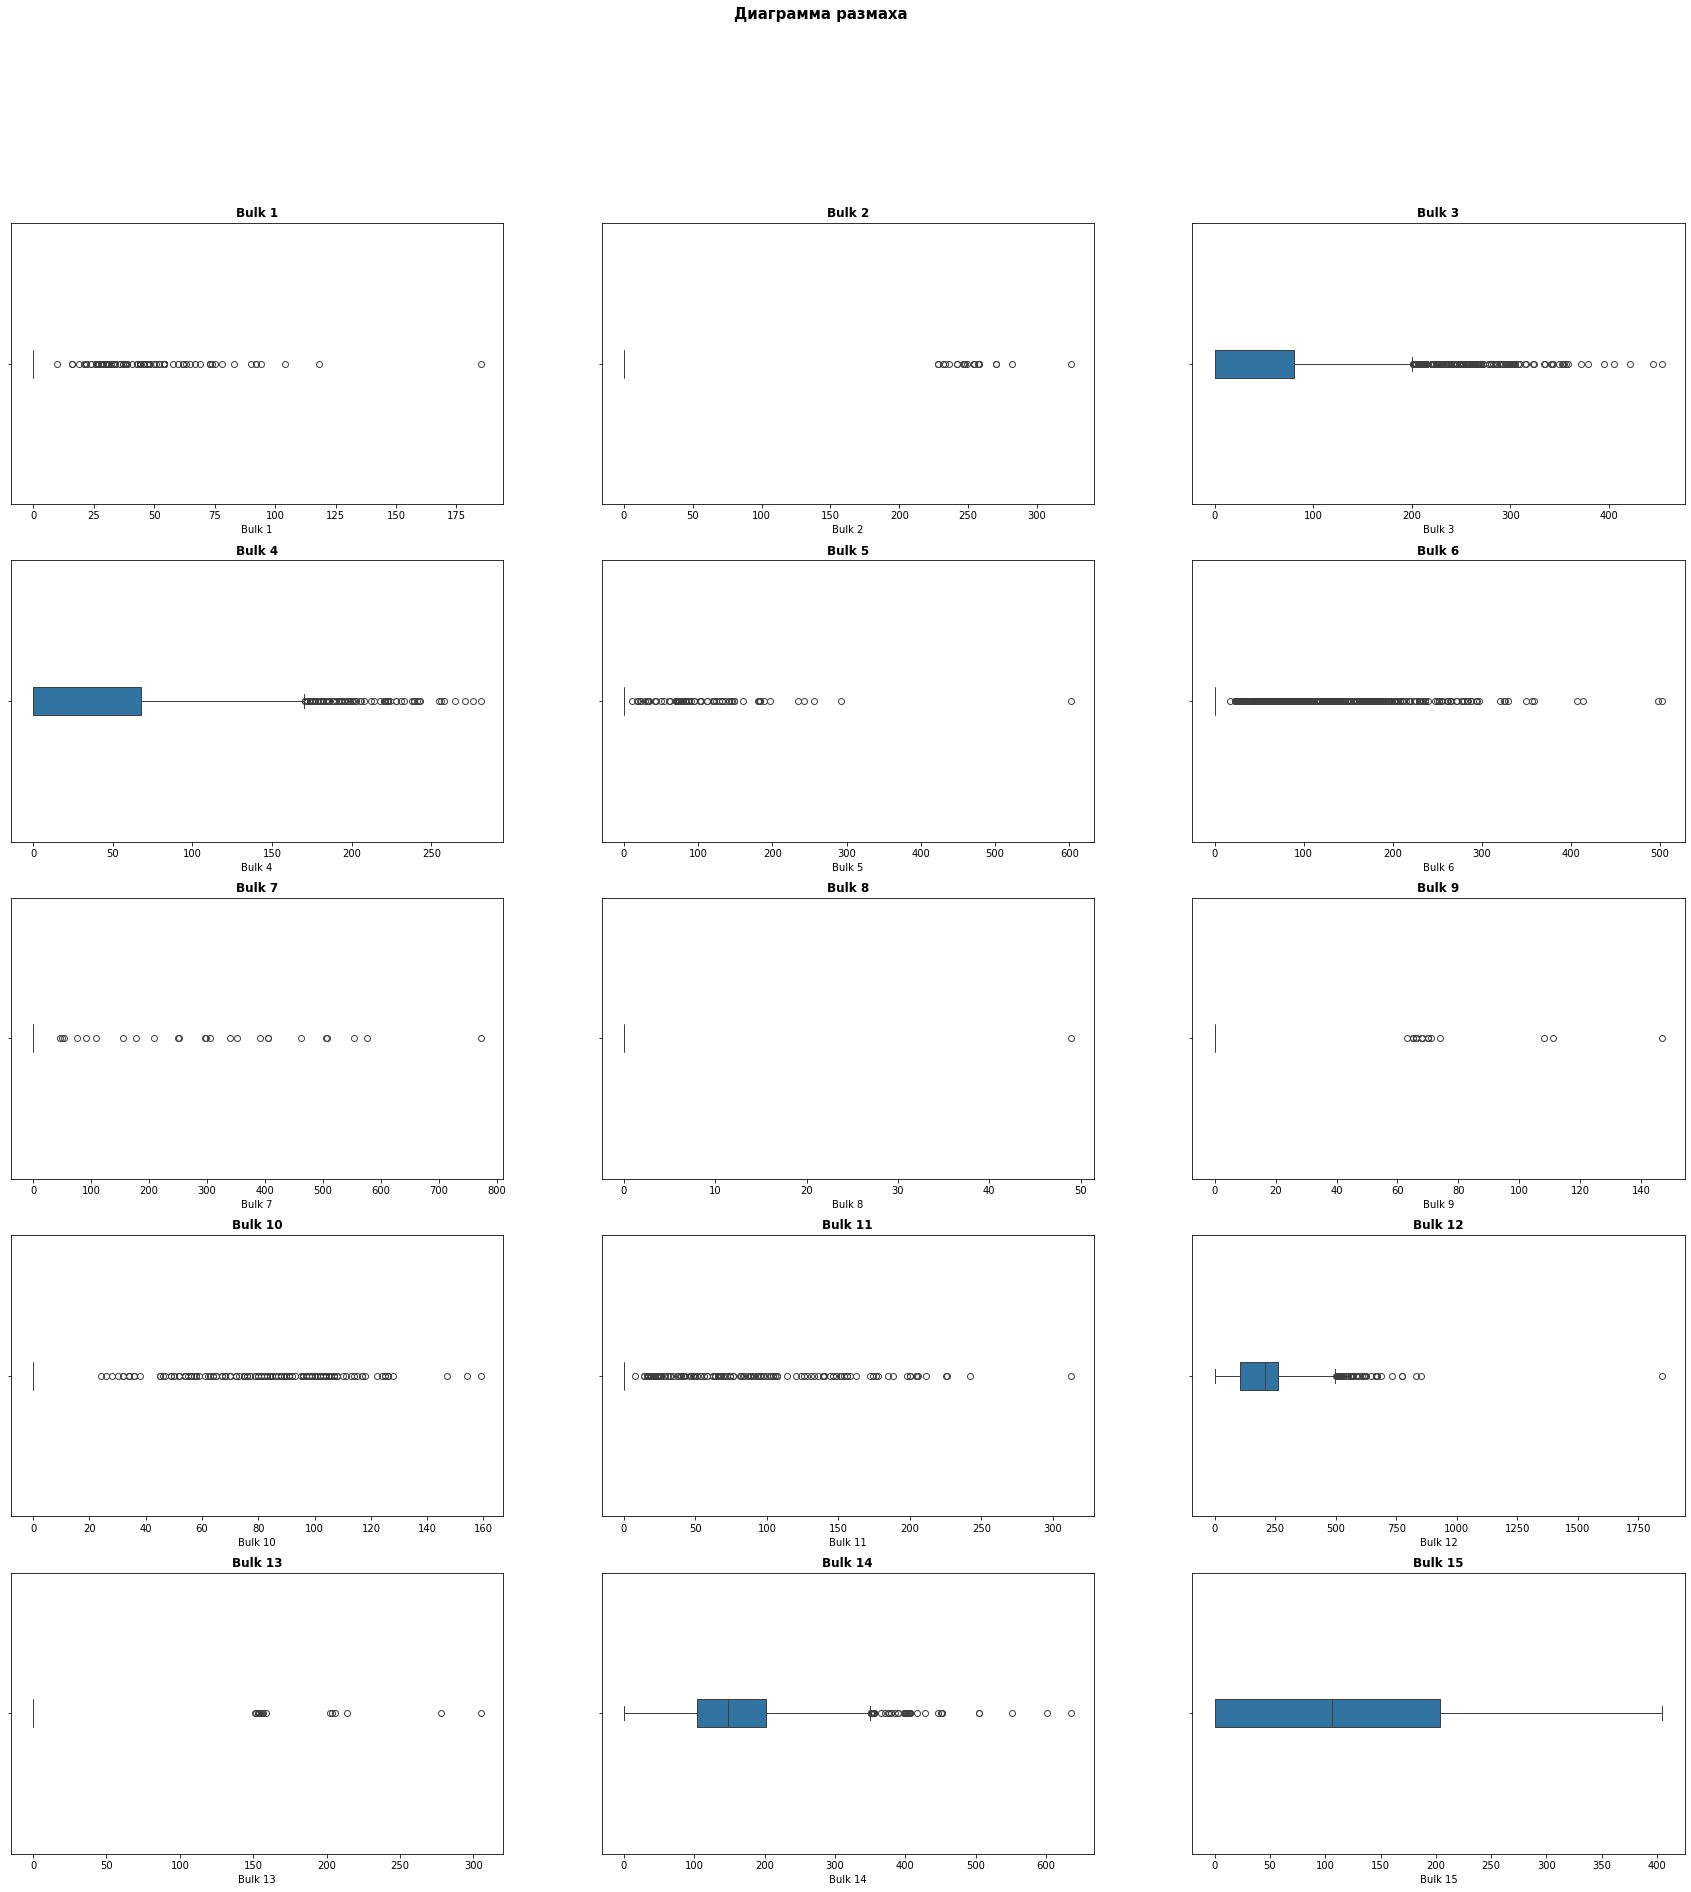

In [52]:
plt.figure(figsize=(30, 30))

plt.suptitle('Диаграмма размаха', fontsize=15, fontweight='bold')

for i in range(1, 16):
    plt.subplot(5, 3, i)
    sns.boxplot(x=data_bulk[f'Bulk {i}'], width=.1)
    plt.title(f'Bulk {i}', fontweight='bold')

plt.show()

У нас всего в 3 столбцах было меньше половины пропусков - 12, 14, 15. Во всех остальных больше половины, поэтому считать аномальными значения мы не будем. Так как большая часть наблюдений заполнены нулями в этих столбцах. В `Bulk 12` есть одно сильно выбивающиеся значение (> 1750), так оно одно, то удалим его.  Также в столбце `Bulk 14` есть 4 сильно выбивающихся значения (>500) их мы тоже удалим.

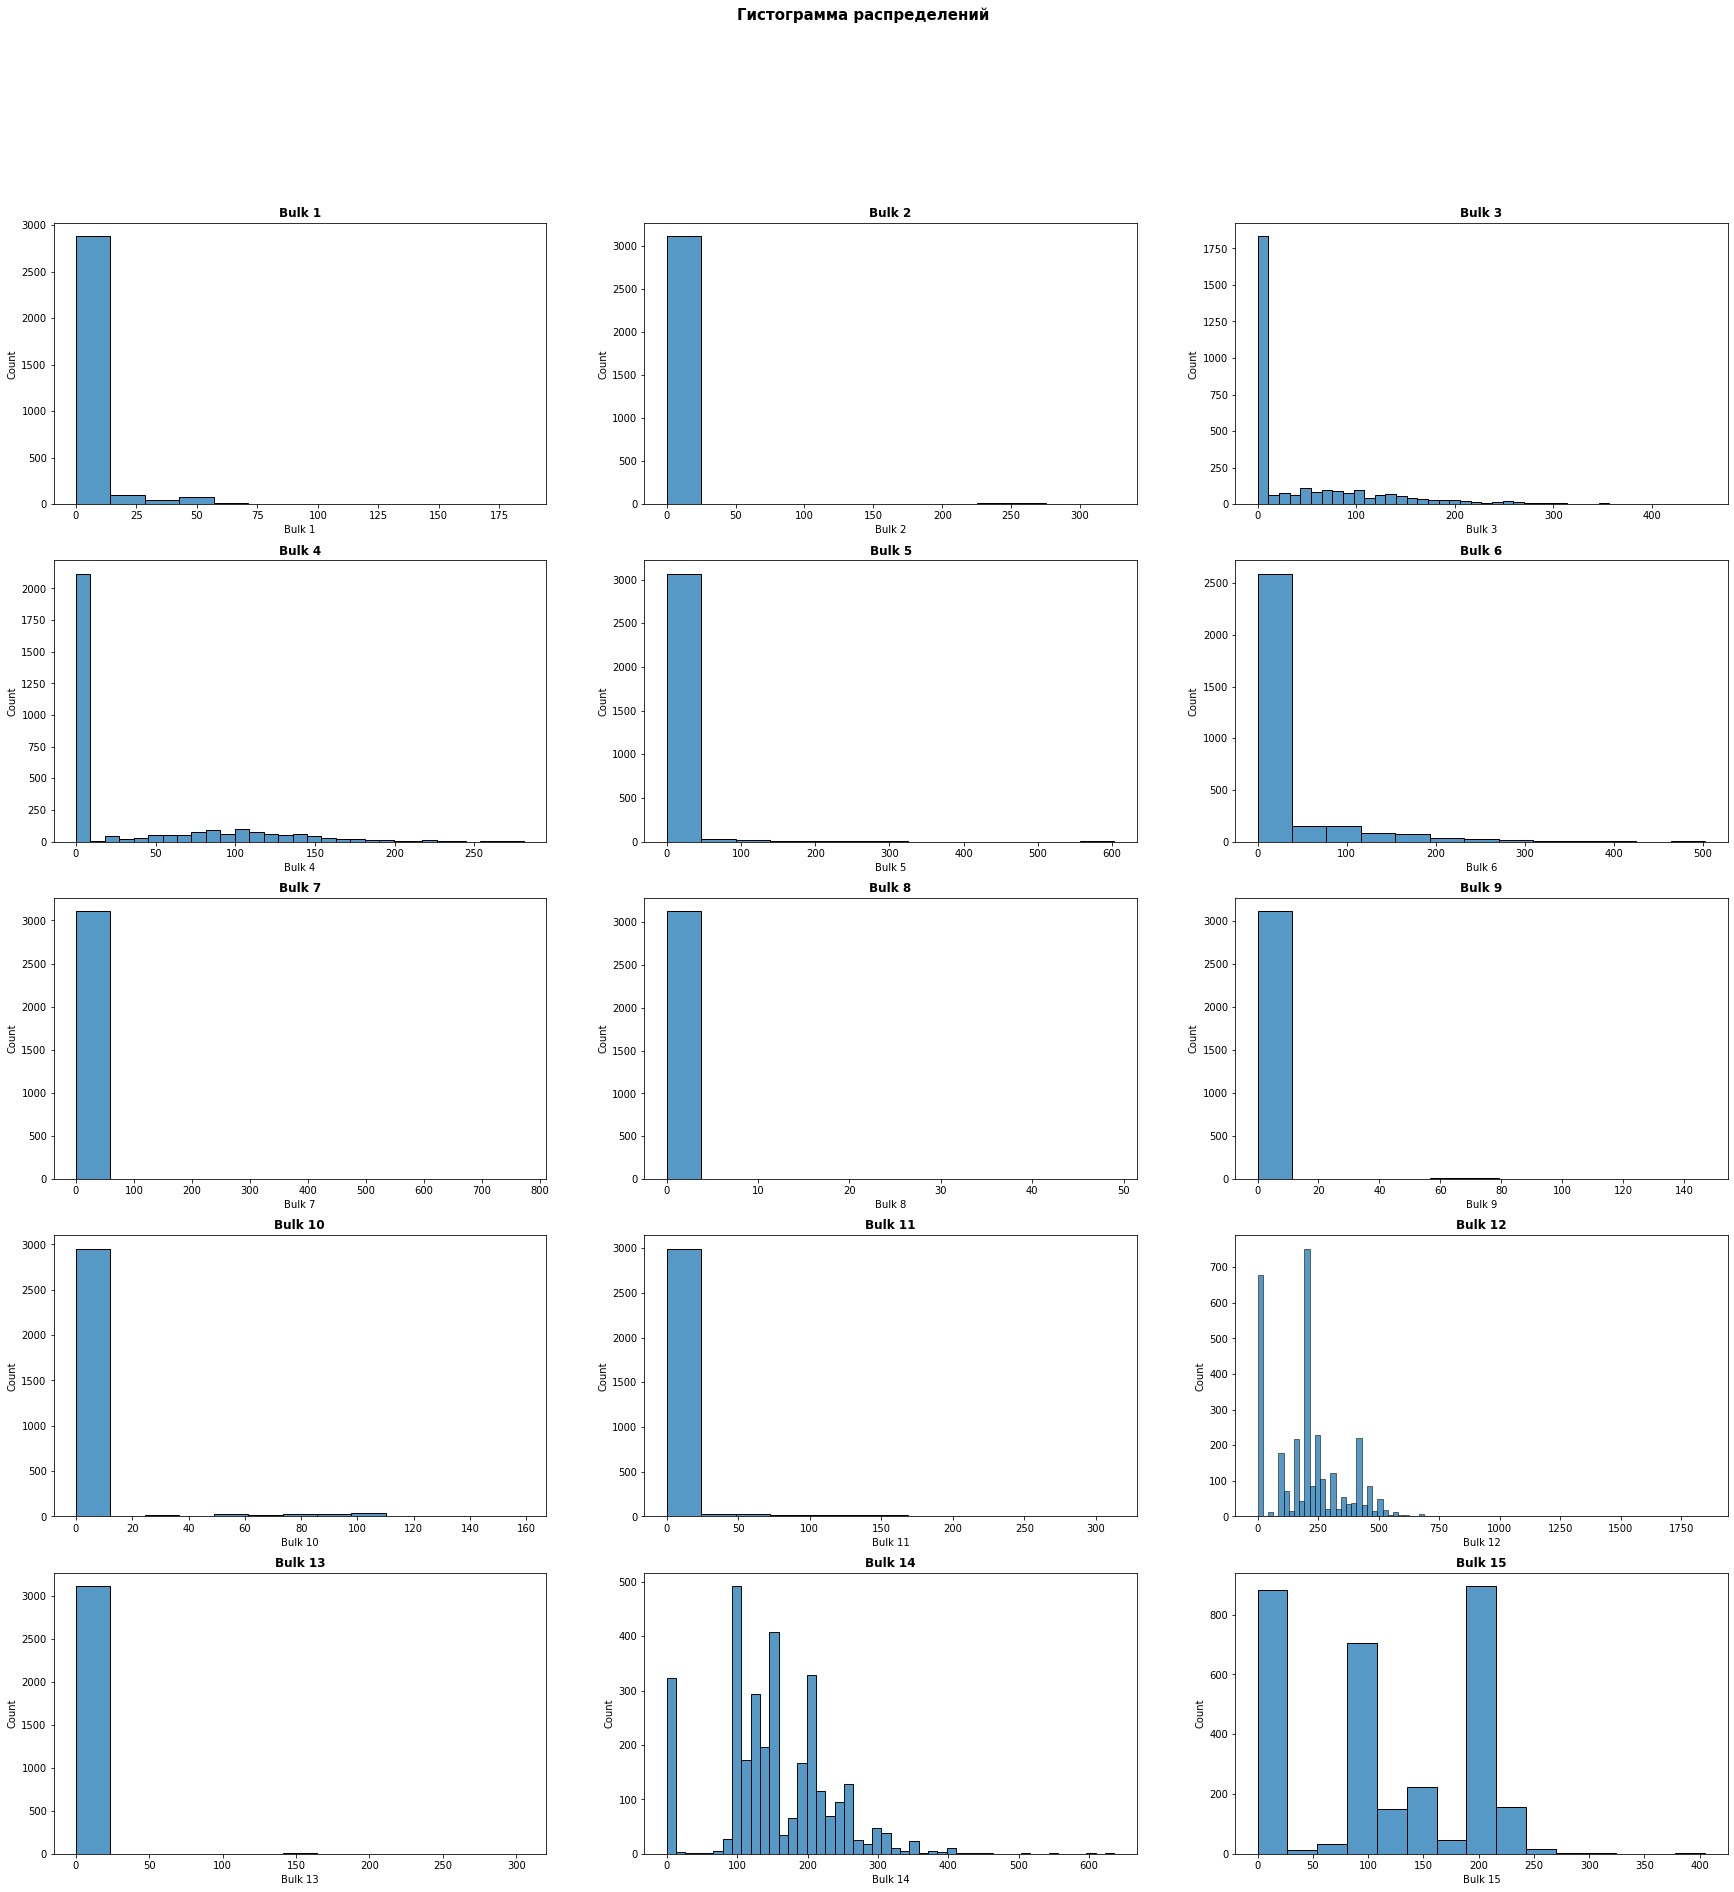

In [53]:
plt.figure(figsize=(30, 30))

plt.suptitle('Гистограмма распределений', fontsize=15, fontweight='bold')

for i in range(1, 16):
    plt.subplot(5, 3, i)
    sns.histplot(data=data_bulk, x=f'Bulk {i}')
    plt.title(f'Bulk {i}', fontweight='bold')

plt.show()

Все данные не имеют нормального распределения. Также проведем для каждого столбца статистический тест `Д’Агостино`, используя функцию `test_normal`. Перед этим необходимо выдвинуть гипотезы:
- **H0** - данные получены из нормального распределения
- **H1** - данные не получены из нормального

Предположим, что верна **H0**, тогда

In [54]:
for i in range(1, 16):
    print(f'###### Bulk {i} ######')
    test_normal(data_bulk[f'Bulk {i}'], ALPHA)
    print(sep='')

###### Bulk 1 ######
Отвегаем H0 и принимаем H1. Данные не получены из нормального распределения

###### Bulk 2 ######
Отвегаем H0 и принимаем H1. Данные не получены из нормального распределения

###### Bulk 3 ######
Отвегаем H0 и принимаем H1. Данные не получены из нормального распределения

###### Bulk 4 ######
Отвегаем H0 и принимаем H1. Данные не получены из нормального распределения

###### Bulk 5 ######
Отвегаем H0 и принимаем H1. Данные не получены из нормального распределения

###### Bulk 6 ######
Отвегаем H0 и принимаем H1. Данные не получены из нормального распределения

###### Bulk 7 ######
Отвегаем H0 и принимаем H1. Данные не получены из нормального распределения

###### Bulk 8 ######
Отвегаем H0 и принимаем H1. Данные не получены из нормального распределения

###### Bulk 9 ######
Отвегаем H0 и принимаем H1. Данные не получены из нормального распределения

###### Bulk 10 ######
Отвегаем H0 и принимаем H1. Данные не получены из нормального распределения

###### Bulk 11 ####

Как и было видно из графиков, наши данные не получены из нормального распределения.

In [55]:
# Удаляем выбивающиеся значение
data_bulk = data_bulk[data_bulk['Bulk 12'] < 1750]

In [56]:
# Удаляем выбивающиеся значение
data_bulk = data_bulk[data_bulk['Bulk 14'] < 500]

## steel.data_bulk_time

In [57]:
# Пишем sql-запрос
query = '''
SELECT *
FROM data_bulk_time
'''

In [58]:
# Записываем результат запроса в датафрейм
data_bulk_time = pd.read_sql_query(query, con=engine)

In [59]:
data_bulk_time.head()  # Смотрим на первые 5 строк

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,None,None,None,2019-05-03 11:28:48,None,None,None,None,None,None,None,2019-05-03 11:24:31,None,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,None,None,None,2019-05-03 11:36:50,None,None,None,None,None,None,None,2019-05-03 11:53:30,None,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,None,None,None,2019-05-03 12:32:39,None,None,None,None,None,None,None,2019-05-03 12:27:13,None,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,None,None,None,2019-05-03 12:43:22,None,None,None,None,None,None,None,2019-05-03 12:58:00,None,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,None,None,None,2019-05-03 13:30:47,None,None,None,None,None,None,None,2019-05-03 13:30:47,None,2019-05-03 13:34:12,2019-05-03 13:30:47


In [60]:
data_bulk_time.info()  # Смотрим инфо о df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


Аналогично таблице `data_bulk`, в большинство столбцов имеют пропуски. Самый заполненый является `Bulk 14`. Также необходимо будет изменить тип данных на datetime.

In [61]:
# Вызываем функцию для подсчета пропусков
count_prop_na(data_bulk_time)

,Пропуск,Доля
Bulk 8,3128,99.968041
Bulk 13,3111,99.424736
Bulk 9,3110,99.392777
Bulk 2,3107,99.296900
Bulk 7,3104,99.201023
Bulk 5,3052,97.539150
Bulk 10,2953,94.375200
Bulk 11,2952,94.343241
Bulk 1,2877,91.946309
Bulk 6,2553,81.591563


In [62]:
# Считаем дубликаты
data_bulk_time.duplicated().sum()

0

In [63]:
# Отбираем нужные столбцы
columns = data_bulk_time.select_dtypes(include='object').columns.to_list()

# Меняем тип данных в цикле
for col in columns:
    data_bulk_time[col] = pd.to_datetime(
        data_bulk_time[col], format='%Y-%m-%d %H:%M:%S')

In [64]:
data_bulk_time.dtypes  # Проверка

key                 int64
Bulk 1     datetime64[ns]
Bulk 2     datetime64[ns]
Bulk 3     datetime64[ns]
Bulk 4     datetime64[ns]
Bulk 5     datetime64[ns]
Bulk 6     datetime64[ns]
Bulk 7     datetime64[ns]
Bulk 8     datetime64[ns]
Bulk 9     datetime64[ns]
Bulk 10    datetime64[ns]
Bulk 11    datetime64[ns]
Bulk 12    datetime64[ns]
Bulk 13    datetime64[ns]
Bulk 14    datetime64[ns]
Bulk 15    datetime64[ns]
dtype: object

In [65]:
data_bulk_time[columns].describe()

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,252,22,1298,1014,77,576,25,1,19,176,177,2450,18,2806,2248
mean,2019-06-29 23:24:44.769841152,2019-07-12 07:57:13.045454592,2019-07-08 13:50:14.630970624,2019-07-03 11:17:28.834319616,2019-07-13 17:18:29.090908928,2019-07-06 13:50:06.345486080,2019-07-27 18:09:05.079999744,2019-07-08 17:14:53,2019-06-23 08:08:47.578947328,2019-07-06 23:55:10.954545408,2019-07-15 07:01:00.615819264,2019-07-05 22:55:11.468571392,2019-07-01 18:32:46.944444416,2019-07-06 07:17:48.372772608,2019-07-06 13:24:51.912366336
min,2019-05-03 17:42:46,2019-05-07 15:39:35,2019-05-03 20:40:25,2019-05-03 11:28:48,2019-05-07 15:19:17,2019-05-03 19:09:15,2019-05-07 18:11:01,2019-07-08 17:14:53,2019-05-14 11:57:58,2019-05-06 07:54:02,2019-05-05 23:43:24,2019-05-03 11:24:31,2019-05-05 02:10:21,2019-05-03 11:14:50,2019-05-03 11:10:43
25%,2019-05-29 14:48:48.500000,2019-05-28 02:29:31.500000,2019-06-08 03:50:23.500000,2019-05-30 21:36:11.249999872,2019-06-19 23:32:44,2019-06-06 22:46:10.500000,2019-07-20 23:48:47,2019-07-08 17:14:53,2019-05-14 14:31:08,2019-06-02 05:12:00.500000,2019-06-14 20:24:48,2019-06-03 12:48:47.249999872,2019-05-29 10:43:31.249999872,2019-06-04 04:50:42,2019-06-04 11:28:18
50%,2019-06-25 11:09:13,2019-07-27 17:18:38.500000,2019-07-04 09:31:42,2019-06-28 03:44:42.500000,2019-07-25 17:59:41,2019-07-09 03:34:57.500000,2019-07-27 18:07:02,2019-07-08 17:14:53,2019-05-14 16:55:09,2019-07-06 07:05:20,2019-07-24 11:17:22,2019-07-03 01:32:00,2019-07-01 12:59:36.500000,2019-07-03 21:54:13.500000,2019-07-03 16:43:28.500000
75%,2019-07-31 05:58:18.249999872,2019-08-13 02:20:08,2019-08-11 01:00:36.750000128,2019-08-04 04:15:46.500000,2019-08-13 04:23:23,2019-08-07 18:55:01.249999872,2019-08-13 04:19:43,2019-07-08 17:14:53,2019-08-16 05:43:31,2019-08-04 02:23:35.750000128,2019-08-11 05:21:01,2019-08-08 14:55:05.249999872,2019-08-04 23:32:00.249999872,2019-08-09 04:22:40.500000,2019-08-09 09:18:31.750000128
max,2019-09-05 09:11:32,2019-08-13 11:47:39,2019-09-06 12:26:52,2019-09-05 03:35:21,2019-09-02 18:16:52,2019-09-06 16:24:28,2019-09-05 19:07:49,2019-07-08 17:14:53,2019-08-16 09:11:56,2019-09-04 10:03:22,2019-09-06 05:03:14,2019-09-06 15:01:44,2019-09-01 01:53:02,2019-09-06 17:26:33,2019-09-06 17:23:15


Временные метки находятся в диапазоне от мая до сентября 2019 года, без явных выбросов или аномальных значений (например, нет дней или недельных интервалов между подачами материалов).

Среднее время между подачей материалов в большинстве случаев составляет меньше 24 часов. Отклонения от среднего значения минимальны, что предполагает стабильный процесс.

## steel.data_gas

In [66]:
# Пишем sql-запрос
query = '''
SELECT *
FROM data_gas
'''

In [67]:
# Записываем результат запроса в датафрейм
data_gas = pd.read_sql_query(query, con=engine)

In [68]:
data_gas.head()  # Смотрим первые 5 строк

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [69]:
data_gas.info()  # Смотрим информацию о df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


Количество строк совпадает, значит пропусков нет. Тип данных соответствует значениям в столбцах. Так как столбец с газом всего один, то для удобства переименуем столбец.

In [70]:
# Переименовываем столбец
data_gas = data_gas.rename(columns={'Газ 1': 'gas'}) 

In [71]:
# Вызываем функцию для подсчета пропусков
count_prop_na(data_gas)

,Пропуск,Доля
key,0,0.0
gas,0,0.0


In [72]:
data_gas.duplicated().sum()  # Считаем дубликаты

0

Приступим к построению графиков.

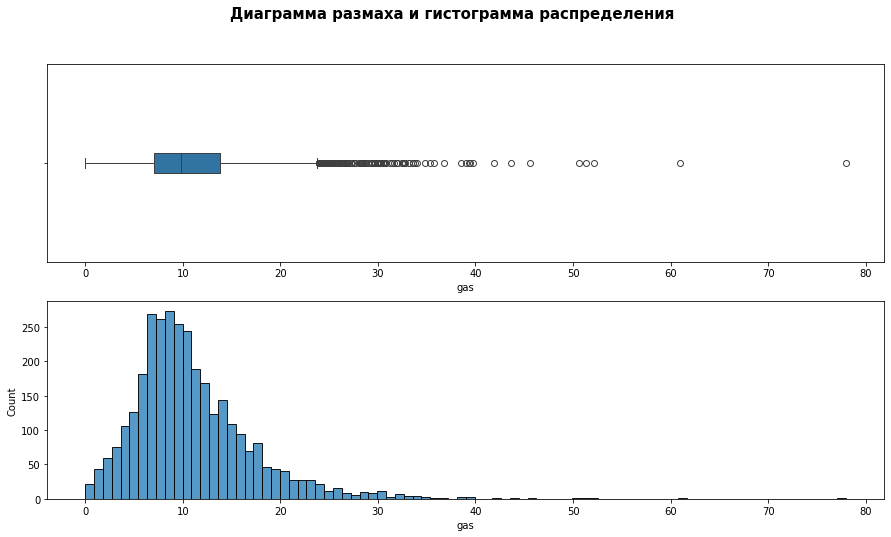

In [73]:
plt.figure(figsize=(15, 8))

plt.suptitle('Диаграмма размаха и гистограмма распределения',
             fontsize=15, fontweight='bold')

plt.subplot(2, 1, 1)
sns.boxplot(x=data_gas['gas'], width=.1)

plt.subplot(2, 1, 2)
sns.histplot(data=data_gas, x='gas')

plt.show()

Хорошо заметно, что подача газа объемом больше `40` очень редкая, поэтому значения больше 40 удалим, так как они выглядят аномальными

In [74]:
data_gas = data_gas[data_gas['gas'] < 40]

Теперь проверим данные на нормальность. Выдвигаем такие же гипотезы и используем функцию `test_normal`. 
- **H0** - данные получены из нормального распределения
- **H1** - данные не получены из нормального распределения

Предположим, что верна **H0**, тогда:

In [75]:
test_normal(data_gas['gas'], ALPHA)

Отвегаем H0 и принимаем H1. Данные не получены из нормального распределения


Визуально тоже видно, что данные не имеют нормального распределения.

## steel.data_temp

Целевой признак — последняя температура партии. Начальную температуру партии можно использовать как входной признак. Любые другие промежуточные значения температуры приведут к утечке целевого признака, их нельзя использовать.

Заказчик предупредил, что значения температуры ниже 1500 градусов — аномальные. Также при агрегировании наблюдений надо использовать только те наблюдения, у которых есть как минимум два наблюдения.

In [76]:
# Пишем sql-запрос
query = '''
SELECT *
FROM data_temp
'''

In [77]:
# Записываем результат запроса в датафрейм
data_temp = pd.read_sql_query(query, con=engine)

In [78]:
data_temp.head()  # Смотрим первые 5 строк

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [79]:
data_temp.info()  # Смотрим информацию о df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   key           18092 non-null  int64 
 1   Время замера  18092 non-null  object
 2   Температура   14665 non-null  object
dtypes: int64(1), object(2)
memory usage: 424.2+ KB


Видно, что в столбце `Температура` есть проущенные значения. Также стоит обратить внимание, что необходимо будет поменять тип данных у двух столбцов.

In [80]:
# Меняем тип данных с object на datetime
data_temp['Время замера'] = pd.to_datetime(
    data_temp['Время замера'], format='%Y-%m-%d %H:%M:%S')

In [81]:
# Меняем тип данных с object на float
data_temp['Температура'] = data_temp['Температура'].astype('float')

In [82]:
# Вызываем функцию для подсчета пропущенных значений
count_prop_na(data_temp)

,Пропуск,Доля
Температура,3427,18.942074
key,0,0.000000
Время замера,0,0.000000


Так как у нас по условию все, что ниже 1500 это аномальное значения, поэтому удалим и пропуски и значения меньше 1500.

In [83]:
# Убираем аномальные значения
data_temp = data_temp[data_temp['Температура'] > 1500]

Также необходимо убрать ту партию, в которых одна температура (нам необходимо, чтобы была начальная и конечная)

In [84]:
data_temp = data_temp[data_temp.groupby('key')['key'].transform('count') >= 2]

Теперь найдем для каждой партии начальную и конечную температуру.

In [85]:
data_temp_total = data_temp.groupby('key').agg(
    temperature=('Температура', 'first'),
    target=('Температура', 'last')).reset_index()

In [86]:
data_temp_total.head()  # Смотрим на первые 5 строк

,key,temperature,target
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0


In [87]:
# Считаем дубликаты
data_temp_total.duplicated().sum()

0

Теперь построим график по итоговому датафрейму

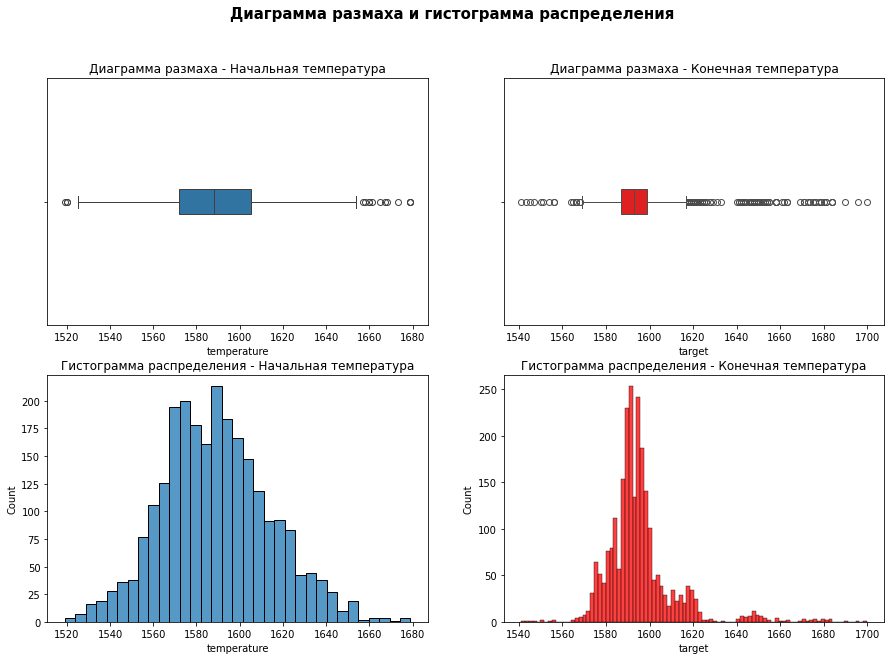

In [88]:
plt.figure(figsize=(15, 10))

plt.suptitle('Диаграмма размаха и гистограмма распределения',
             fontsize=15, fontweight='bold')

plt.subplot(2, 2, 1)
sns.boxplot(x=data_temp_total['temperature'], width=.1)
plt.title('Диаграмма размаха - Начальная температура')

plt.subplot(2, 2, 2)
sns.boxplot(x=data_temp_total['target'], width=.1, color='red')
plt.title('Диаграмма размаха - Конечная температура')

plt.subplot(2, 2, 3)
sns.histplot(data=data_temp_total, x='temperature')
plt.title('Гистограмма распределения - Начальная температура')

plt.subplot(2, 2, 4)
sns.histplot(data=data_temp_total, x='target', color='red')
plt.title('Гистограмма распределения - Конечная температура')

plt.show()

Видно, что аномальных значений нет, так как до этого мы уже удалили их (<1500), а с правой стороны максимальная температура чуть больше 1700, что не является аномальным.

По гистограммам видно, что данные распределены не номарльно, но также проведем статистический тест. Воспользуемся функцией `test_normal`. Выдвиним гипотезы:
- **H0** - даннные получены из нормального распределения
- **H1** - данные не получены из нормального распределения

Предположим, что верна **H0**, тогда:

In [89]:
test_normal(data_temp_total['temperature'], ALPHA)

Отвегаем H0 и принимаем H1. Данные не получены из нормального распределения


In [90]:
test_normal(data_temp_total['target'], ALPHA)

Отвегаем H0 и принимаем H1. Данные не получены из нормального распределения


## steel.data_wire

In [91]:
# Пишем sql-запрос
query = '''
SELECT *
FROM data_wire
'''

In [92]:
# Записываем результат запроса в датафрейм
data_wire = pd.read_sql_query(query, con=engine)

In [93]:
data_wire.head()  # Смотрим первые 5 строк

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,None,None,None,None,None,None,None,None
1,2,96.052315,None,None,None,None,None,None,None,None
2,3,91.160157,None,None,None,None,None,None,None,None
3,4,89.063515,None,None,None,None,None,None,None,None
4,5,89.238236,9.11456,None,None,None,None,None,None,None


In [94]:
data_wire.info()  # Смотрим информацию о df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   object 
 3   Wire 3  63 non-null     object 
 4   Wire 4  14 non-null     object 
 5   Wire 5  1 non-null      object 
 6   Wire 6  73 non-null     object 
 7   Wire 7  11 non-null     object 
 8   Wire 8  19 non-null     object 
 9   Wire 9  29 non-null     object 
dtypes: float64(1), int64(1), object(8)
memory usage: 240.8+ KB


Видно, что в данных много пропущенных значений. В данном случае пропуск означает, что материал недобавляли в партию, а значит все пропуски заполним нулями. Также необходимо помять тип данных с `object` на `float`.

In [95]:
# Отбираем столбцы с типом данных object
columns = data_wire.select_dtypes(include='object').columns.to_list()

In [96]:
# Меняем в цикле тип данных с object на float
for col in columns:
    data_wire[col] = data_wire[col].astype('float')

In [97]:
data_wire.dtypes  # Смотрим на результат

key         int64
Wire 1    float64
Wire 2    float64
Wire 3    float64
Wire 4    float64
Wire 5    float64
Wire 6    float64
Wire 7    float64
Wire 8    float64
Wire 9    float64
dtype: object

In [98]:
# Вызываем функцию для подсчета пропусков
count_prop_na(data_wire)

,Пропуск,Доля
Wire 5,3080,99.967543
Wire 7,3070,99.642973
Wire 4,3067,99.545602
Wire 8,3062,99.383317
Wire 9,3052,99.058747
Wire 3,3018,97.955209
Wire 6,3008,97.630639
Wire 2,2002,64.978903
Wire 1,26,0.843882
key,0,0.000000


In [99]:
# Заполняем нулями
data_wire = data_wire.fillna(0)

In [100]:
# Считаем дубликаты
data_wire.duplicated().sum()

0

В данном случае есть смысл посмотреть на распределение признаков только у столбца `Wire 1`, так как только у него доля пропусков меньше 50%

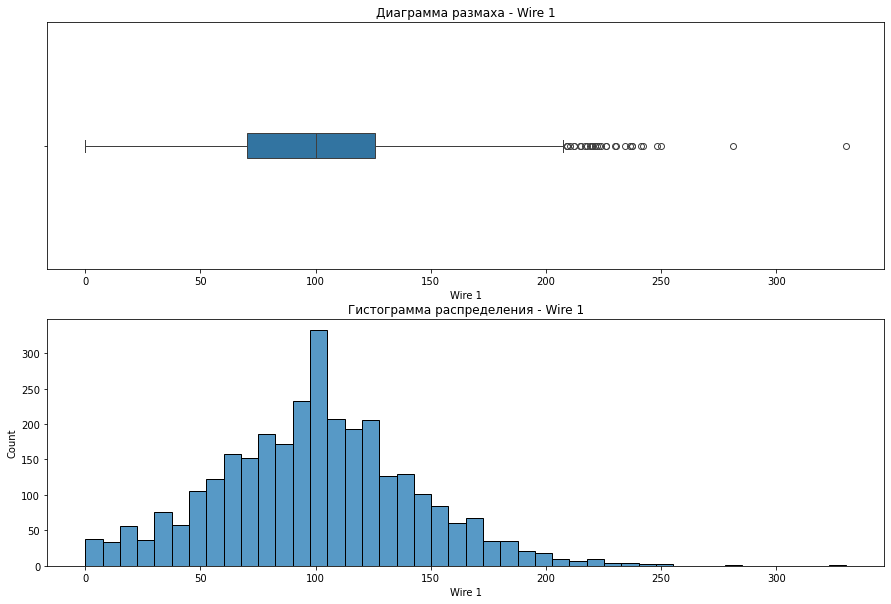

In [101]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
sns.boxplot(x=data_wire['Wire 1'], width=.1)
plt.title('Диаграмма размаха - Wire 1')

plt.subplot(2, 1, 2)
sns.histplot(data=data_wire, x='Wire 1')
plt.title('Гистограмма распределения - Wire 1')
plt.show()

Значение больше 250 будем считать аномальными и удалим их.

In [102]:
data_wire = data_wire[data_wire['Wire 1'] < 250]

Теперь проведем тест на нормальность. Выдвигаем гипотезы:
- **H0** - данные получены из нормального распределения
- **H1** - данные не получены из нормального распределения

In [103]:
test_normal(data_wire['Wire 1'], ALPHA)

Отвегаем H0 и принимаем H1. Данные не получены из нормального распределения


Тест подтверждает то, что было видно визуально.

## steel.data_wire_time

In [104]:
# Пишем sql-запрос
query = '''
SELECT *
FROM data_wire_time
'''

In [105]:
# Записываем результат запроса в датафрейм
data_wire_time = pd.read_sql_query(query, con=engine)

In [106]:
data_wire_time.head()  # Смотрим первые 5 строк

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,None,None,None,None,None,None,None,None
1,2,2019-05-03 11:36:50,None,None,None,None,None,None,None,None
2,3,2019-05-03 12:11:46,None,None,None,None,None,None,None,None
3,4,2019-05-03 12:43:22,None,None,None,None,None,None,None,None
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,None,None,None,None,None,None,None


In [107]:
data_wire_time.info()  # Смотрим инфо о df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


Аналогично таблице `data_wire`, в большинство столбцов имеют пропуски. Самый заполненый является `Wire 1`. Также необходимо будет изменить тип данных на datetime

In [108]:
# Вызываем функцию для подсчета пропусков
count_prop_na(data_wire_time)

,Пропуск,Доля
Wire 5,3080,99.967543
Wire 7,3070,99.642973
Wire 4,3067,99.545602
Wire 8,3062,99.383317
Wire 9,3052,99.058747
Wire 3,3018,97.955209
Wire 6,3008,97.630639
Wire 2,2002,64.978903
Wire 1,26,0.843882
key,0,0.000000


In [109]:
# Считаем дубликаты
data_wire_time.duplicated().sum()

0

Изменим тип данных в столбцах

In [110]:
# Выделяем столбцы
columns = data_wire_time.select_dtypes(include='object').columns.to_list()

# Изменяем тип данных в цикле
for col in columns:
    data_wire_time[col] = pd.to_datetime(
        data_wire_time[col], format='%Y-%m-%d %H:%M:%S')

In [111]:
data_wire_time.dtypes  # Проверка

key                int64
Wire 1    datetime64[ns]
Wire 2    datetime64[ns]
Wire 3    datetime64[ns]
Wire 4    datetime64[ns]
Wire 5    datetime64[ns]
Wire 6    datetime64[ns]
Wire 7    datetime64[ns]
Wire 8    datetime64[ns]
Wire 9    datetime64[ns]
dtype: object

In [112]:
data_wire_time[columns].describe()

,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3055,1079,63,14,1,73,11,19,29
mean,2019-07-05 23:22:34.279541760,2019-07-07 01:07:08.735866624,2019-07-10 15:09:58.650793472,2019-07-11 13:44:37,2019-08-13 06:14:30,2019-07-07 11:51:15.095890432,2019-08-07 01:16:08.090909184,2019-06-23 07:47:49.052631552,2019-07-01 11:56:04.793103616
min,2019-05-03 11:06:19,2019-05-03 13:15:34,2019-05-04 04:34:27,2019-05-07 15:19:17,2019-08-13 06:14:30,2019-05-07 14:46:05,2019-07-27 05:49:05,2019-05-14 11:29:24,2019-05-04 17:21:27
25%,2019-06-04 19:30:11.500000,2019-06-05 14:50:26.500000,2019-06-11 14:17:38.500000,2019-07-20 17:58:53.750000128,2019-08-13 06:14:30,2019-05-08 21:47:30,2019-07-27 16:27:27,2019-05-14 14:20:07.500000,2019-06-09 19:36:17
50%,2019-07-03 06:36:23,2019-07-04 23:13:39,2019-07-21 10:04:47,2019-07-27 05:45:26.500000,2019-08-13 06:14:30,2019-07-28 05:00:32,2019-08-12 21:48:11,2019-05-14 16:55:09,2019-06-11 10:10:21
75%,2019-08-08 08:56:06.500000,2019-08-08 23:15:17,2019-08-12 22:54:46,2019-07-27 16:20:04.750000128,2019-08-13 06:14:30,2019-08-13 13:33:02,2019-08-13 02:02:55.500000,2019-08-16 05:06:53.500000,2019-08-09 06:49:04
max,2019-09-06 17:10:06,2019-09-06 07:35:40,2019-09-02 07:14:44,2019-08-13 03:16:45,2019-08-13 06:14:30,2019-08-18 19:10:56,2019-08-13 10:25:22,2019-08-16 08:56:23,2019-09-03 12:55:23


Временные метки находятся в диапазоне от мая до сентября 2019 года, без явных выбросов или аномальных значений (например, нет дней или недельных интервалов между подачами материалов).

Среднее время между подачей материалов в большинстве случаев составляет меньше 24 часов. Отклонения от среднего значения минимальны, что предполагает стабильный процесс.

## Вывод

Подведем итоги. Провели анализ для каждой из таблиц. 
- В таблице `data_arc` не было ни одного пропуска и дубликата, но были неправильные типы данных у двух столбцов. Перевели их в тип `datetime`. Также в столбце `Рекативная мощность` было найдено аномальное значение, которое мы удалили. Все данные распределены ненормально. Также сгенерировали новые признаки: длительность нагрева, общую мощность, соотношение активной мощности к реактивной, количество запуска нагрева электродами.
- В таблице `data_bulk` в большинстве признаков были пропущенные значение. Мы их заполнили, так как пропуск означал, что материал не подавался. Перевели все столбцы в тип данных `float`. В столбцах `Bulk 12` и `Bulk 14` было найдено по одному аномальному значению, которые были удалены. Все данные распределены ненормально.
- В таблице `data_bulk_time` было много пропущенных значений, так как она связана с предыдущей. Удалять мы их не стали. Перевели столбцы в формат `datetime`. Временные метки находятся в диапазоне от мая до сентября 2019 года, без явных выбросов или аномальных значений (например, нет дней или недельных интервалов между подачами материалов). Среднее время между подачей материалов в большинстве случаев составляет меньше 24 часов. Отклонения от среднего значения минимальны, что предполагает стабильный процесс.
- В таблице `data_gas` не было ни одного пропущенного значения и дубликата. Были найдены несколько аномальных значений, которые мы удалили. Данные в данном датафрейме имеют ненормальное распределение
- В таблице `data_temp` в одном столбце были найдены пропуски. Дубликатов не обнаружили. Перевели столбцы в нужный тип данных. Удалили аномальные значения исходя из условия заказчика (<1500 - это аномалия). Также нас интересовали партии, в которых были данные о начальной температуре и конечной. Конечная температура — наш таргет. Все данные распределены ненормально
- В таблице `data_wire` много пропущенных значений и нет дубликатов. Заполнили пропуски по аналогии с `data_bulk`. Перевели столбцы в нужный тип данных. Также в столбце `Wire 1` удалили аномальные значения. Данные имеют ненормальное распределение.
- В таблице `data_wire_temp` также много пропущенных значений по аналогии с предыдущей таблицей. Их также не стали удалять, так как это означало, что данный материал не подавался. Перевели данный в нужный формат. Временные метки находятся в диапазоне от мая до сентября 2019 года, без явных выбросов или аномальных значений (например, нет дней или недельных интервалов между подачами материалов). Среднее время между подачей материалов в большинстве случаев составляет меньше 24 часов. Отклонения от среднего значения минимальны, что предполагает стабильный процесс.

# Объединение таблиц

Объединим все таблицы в одну. Стоит отметить, что каждой партии должно соответствовать одно наблюдение.

In [113]:
# Обьединяем данные о сыпучих материалах
bulk_time = data_bulk.merge(data_bulk_time, on='key',
                    how='inner', suffixes=('', '_time'))

In [114]:
bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Bulk 1_time,Bulk 2_time,Bulk 3_time,Bulk 4_time,Bulk 5_time,Bulk 6_time,Bulk 7_time,Bulk 8_time,Bulk 9_time,Bulk 10_time,Bulk 11_time,Bulk 12_time,Bulk 13_time,Bulk 14_time,Bulk 15_time
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47


In [115]:
# Обьединяем данные о проволочных материалов
wire_time = data_wire.merge(
    data_wire_time, on='key', how='inner', suffixes=('', '_time'))

In [116]:
wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Wire 1_time,Wire 2_time,Wire 3_time,Wire 4_time,Wire 5_time,Wire 6_time,Wire 7_time,Wire 8_time,Wire 9_time
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [117]:
# Обьединяем данные проволочных и сыпучих материалов
bulk_wire = bulk_time.merge(wire_time, on='key', how='inner')

In [118]:
bulk_wire.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Bulk 1_time,Bulk 2_time,Bulk 3_time,Bulk 4_time,Bulk 5_time,Bulk 6_time,Bulk 7_time,Bulk 8_time,Bulk 9_time,Bulk 10_time,Bulk 11_time,Bulk 12_time,Bulk 13_time,Bulk 14_time,Bulk 15_time,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Wire 1_time,Wire 2_time,Wire 3_time,Wire 4_time,Wire 5_time,Wire 6_time,Wire 7_time,Wire 8_time,Wire 9_time
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [119]:
# Обьединяем данные о газе и температуре
gas_temp = data_gas.merge(data_temp_total, on='key', how='inner')

In [120]:
gas_temp.head()

,key,gas,temperature,target
0,1,29.749986,1571.0,1613.0
1,2,12.555561,1581.0,1602.0
2,3,28.554793,1596.0,1599.0
3,4,18.841219,1601.0,1625.0
4,5,5.413692,1576.0,1602.0


In [121]:
# Обьединяем получившиеся датафреймы
gas_temp_bulk_wire = gas_temp.merge(bulk_wire, on='key', how='inner')

In [122]:
gas_temp_bulk_wire.head()

,key,gas,temperature,target,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Bulk 1_time,Bulk 2_time,Bulk 3_time,Bulk 4_time,Bulk 5_time,Bulk 6_time,Bulk 7_time,Bulk 8_time,Bulk 9_time,Bulk 10_time,Bulk 11_time,Bulk 12_time,Bulk 13_time,Bulk 14_time,Bulk 15_time,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Wire 1_time,Wire 2_time,Wire 3_time,Wire 4_time,Wire 5_time,Wire 6_time,Wire 7_time,Wire 8_time,Wire 9_time
0,1,29.749986,1571.0,1613.0,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,12.555561,1581.0,1602.0,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,28.554793,1596.0,1599.0,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,18.841219,1601.0,1625.0,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,5.413692,1576.0,1602.0,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [123]:
# Обьединяем электроды с получившимся датафреймом
total_df = gas_temp_bulk_wire.merge(data_arc, on='key', how='left')

In [124]:
# Удаляем дубликаты
total_df = total_df.drop_duplicates(subset='key')

In [125]:
total_df.head()

,key,gas,temperature,target,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Bulk 1_time,Bulk 2_time,Bulk 3_time,Bulk 4_time,Bulk 5_time,Bulk 6_time,Bulk 7_time,Bulk 8_time,Bulk 9_time,Bulk 10_time,Bulk 11_time,Bulk 12_time,Bulk 13_time,Bulk 14_time,Bulk 15_time,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Wire 1_time,Wire 2_time,Wire 3_time,Wire 4_time,Wire 5_time,Wire 6_time,Wire 7_time,Wire 8_time,Wire 9_time,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Общая мощность,Активная/Реактивная,Длительность нагрева,Количество нагревов
0,1,29.749986,1571.0,1613.0,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:02:14,2019-05-03 11:06:02,3.036730,2.142821,5.179551,1.417165,0 days 00:18:18,5
5,2,12.555561,1581.0,1602.0,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:34:14,2019-05-03 11:36:31,2.139408,1.453357,3.592765,1.472046,0 days 00:13:31,4
9,3,28.554793,1596.0,1599.0,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:06:54,2019-05-03 12:11:34,4.063641,2.937457,7.001098,1.383387,0 days 00:10:55,5
14,4,18.841219,1601.0,1625.0,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:39:37,2019-05-03 12:43:04,2.706489,2.056992,4.763481,1.315751,0 days 00:12:21,4
18,5,5.413692,1576.0,1602.0,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:11:13,2019-05-03 13:15:24,2.252950,1.687991,3.940941,1.334693,0 days 00:14:29,4


In [126]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2321 entries, 0 to 10865
Data columns (total 60 columns):
 #   Column                Non-Null Count  Dtype          
---  ------                --------------  -----          
 0   key                   2321 non-null   int64          
 1   gas                   2321 non-null   float64        
 2   temperature           2321 non-null   float64        
 3   target                2321 non-null   float64        
 4   Bulk 1                2321 non-null   float64        
 5   Bulk 2                2321 non-null   float64        
 6   Bulk 3                2321 non-null   float64        
 7   Bulk 4                2321 non-null   float64        
 8   Bulk 5                2321 non-null   float64        
 9   Bulk 6                2321 non-null   float64        
 10  Bulk 7                2321 non-null   float64        
 11  Bulk 8                2321 non-null   float64        
 12  Bulk 9                2321 non-null   float64        
 13  Bulk 10

Столбец `Длительность нагрева` имеет формат timedelta для удобства переведем все в минуты (float)

In [127]:
total_df['Длительность нагрева'] = total_df['Длительность нагрева'].apply(
    lambda x: x.seconds / 60)

# Исследовательский анализ итогового датафрейма

Анализ и визуализация большинства признаков была ранее, хоть наблюдений стало немного меньше их распределение останется таким же, так как большинство признаков связаны с сыпучими и проволочными материалами, у них же большинство значений является ноль. Поэтому имеет смысл рассмотреть новые признаки, а именно: `Общая мощность`, `Активная/Реактивная`, `Количество нагревов` и `Длительность нагрева`. А также признаки из датафрейма data_bulk, так как существенно уменьшилось количество наблюдений: `Активная мощность`, `Реактивная мощность`, `Начало нагрева дугой` и `Конец нагрева дугой`.

In [128]:
# Выписываем название столбцов
columns = ['Общая мощность', 'Активная/Реактивная', 'Количество нагревов', 'Длительность нагрева',
           'Активная мощность', 'Реактивная мощность', 'Начало нагрева дугой', 'Конец нагрева дугой']

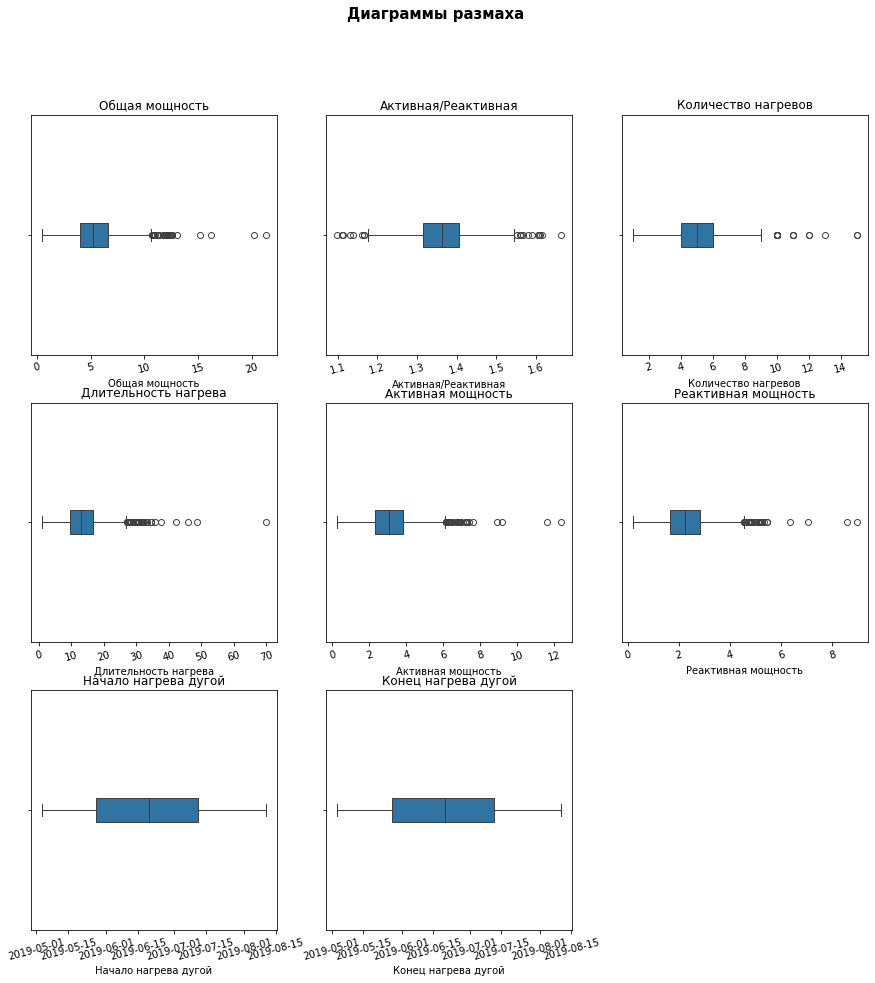

In [129]:
plt.figure(figsize=(15, 15))

plt.suptitle('Диаграммы размаха', fontsize=15, fontweight='bold')

for i in range(len(columns)):
    plt.subplot(3, 3, i+1)
    sns.boxplot(x=total_df[columns[i]], width=.1)
    plt.title(f'{columns[i]}')
    plt.xticks(rotation=15)

В целом все значения не выглядят аномальными, хоть и выходят за пределы "усов". Но стоит обратить внимание на одно значение в `Длительность нагрева`, которое принимает значение практически равное 70. На данный момент удалять это значение не буду, но если будут какие-то проблемы с обучением модели, стоит вернуться к нему.

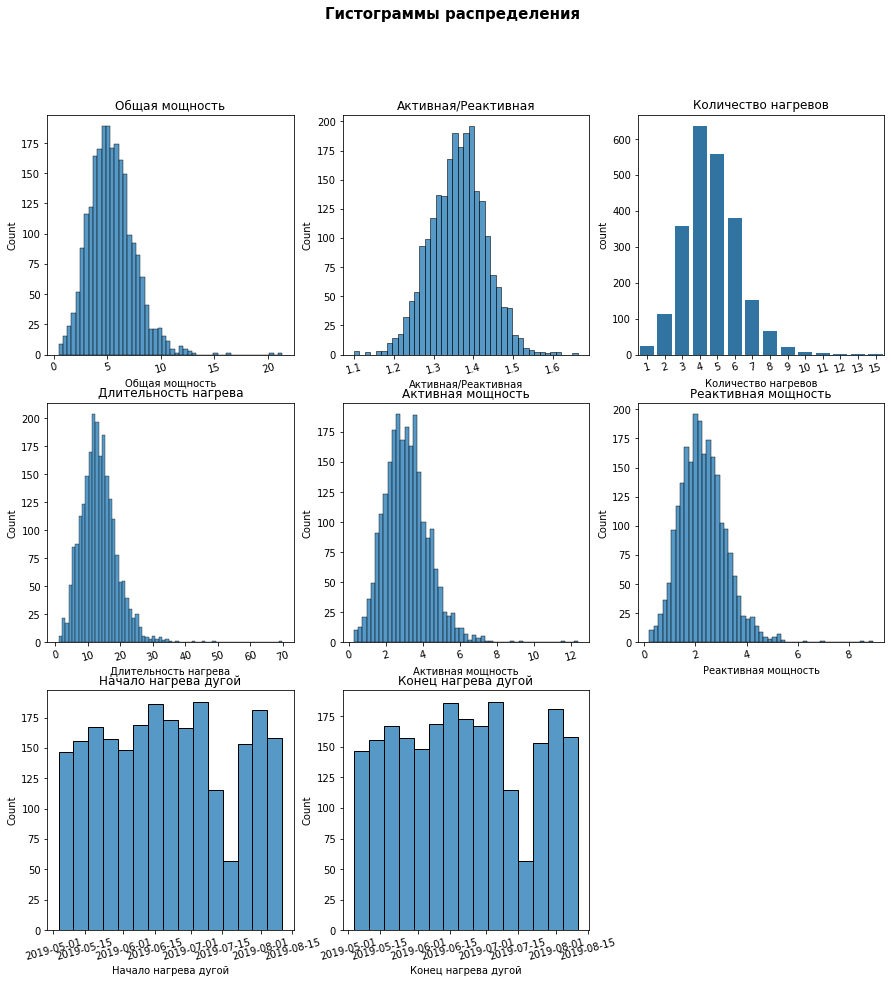

In [130]:
plt.figure(figsize=(15, 15))

plt.suptitle('Гистограммы распределения', fontsize=15, fontweight='bold')

for i in range(len(columns)):
    try:
        plt.subplot(3, 3, i+1)
        if columns[i] == 'Количество нагревов':
            sns.countplot(data=total_df, x=columns[i])
        else:
            sns.histplot(data=total_df, x=columns[i])
        plt.title(f'{columns[i]}')
        plt.xticks(rotation=15)
    except:
        print(f'График {columns[i]} не удалось построить')

Все данные распределены не нормальною. Убедимся в этом проверя наши данные на нормальность, используя ранее написаную функцию `test_normal`. Перед этим необходимо сформулировать гипотезы:
- **H0** - данные получены из нормального распределения
- **H1** - данные не получены из нормального распределения

Предположим, что верна **H0**, тогда:

In [131]:
for col in columns:
    try:
        print(f'#### {col} ####')
        test_normal(total_df[col], ALPHA)
        print(sep='')
    except:
        print(f'Столбец {col} нельзя проверить')
        print(sep='')

#### Общая мощность ####
Отвегаем H0 и принимаем H1. Данные не получены из нормального распределения

#### Активная/Реактивная ####
Отвегаем H0 и принимаем H1. Данные не получены из нормального распределения

#### Количество нагревов ####
Отвегаем H0 и принимаем H1. Данные не получены из нормального распределения

#### Длительность нагрева ####
Отвегаем H0 и принимаем H1. Данные не получены из нормального распределения

#### Активная мощность ####
Отвегаем H0 и принимаем H1. Данные не получены из нормального распределения

#### Реактивная мощность ####
Отвегаем H0 и принимаем H1. Данные не получены из нормального распределения

#### Начало нагрева дугой ####
Столбец Начало нагрева дугой нельзя проверить

#### Конец нагрева дугой ####
Столбец Конец нагрева дугой нельзя проверить



## Вывод

Провели анализ для итогового датафрейма, так большинство признаков уже были проанализированы ранее. То в данном разделе анализировали только новые столбцы и столбцы, которые сильно уменьшились после объединения: `Общая мощность`, `Активная/Реактивная`, `Количество нагревов`, `Длительность нагрева`, `Активная мощность`, `Реактивная мощность`, `Начало нагрева дугой` и `Конец нагрева дугой`.

Столбцу `Длительность нагрева` поменяли тип данных с timedelta на float и перевели значения в минуты. В результате анализа каких-то аномальных значений найдено не было, но взяли себе на заметку одно наблюдение в столбце `Длительность нагрева`. В дальнейшем оно может быть удалено. Построили гистограммы распределений и убедились визуально и статистически, что данные распределены ненормально. Можно сказать, что данное количество признаков сократиться (60), так как часть из них должна коррелировать между собой, а некоторые не несут в себе никакой полезной информации. Для этого можно приступать к следующей части — корреляционному анализу.

# Корреляционный анализ

Исходя из исследовательского анализа выяснили, что наши данные распределены ненормально, поэтому для изучения взаимосвязи воспользуемся коэффициентом корреляции $\phi_K$.

In [132]:
# Расчитываем коэффициент корреляции Фи
phik_matrix = total_df.drop(columns=['key'], axis=1).phik_matrix(
    interval_cols=total_df.select_dtypes(include=['float', 'int']).columns.to_list())

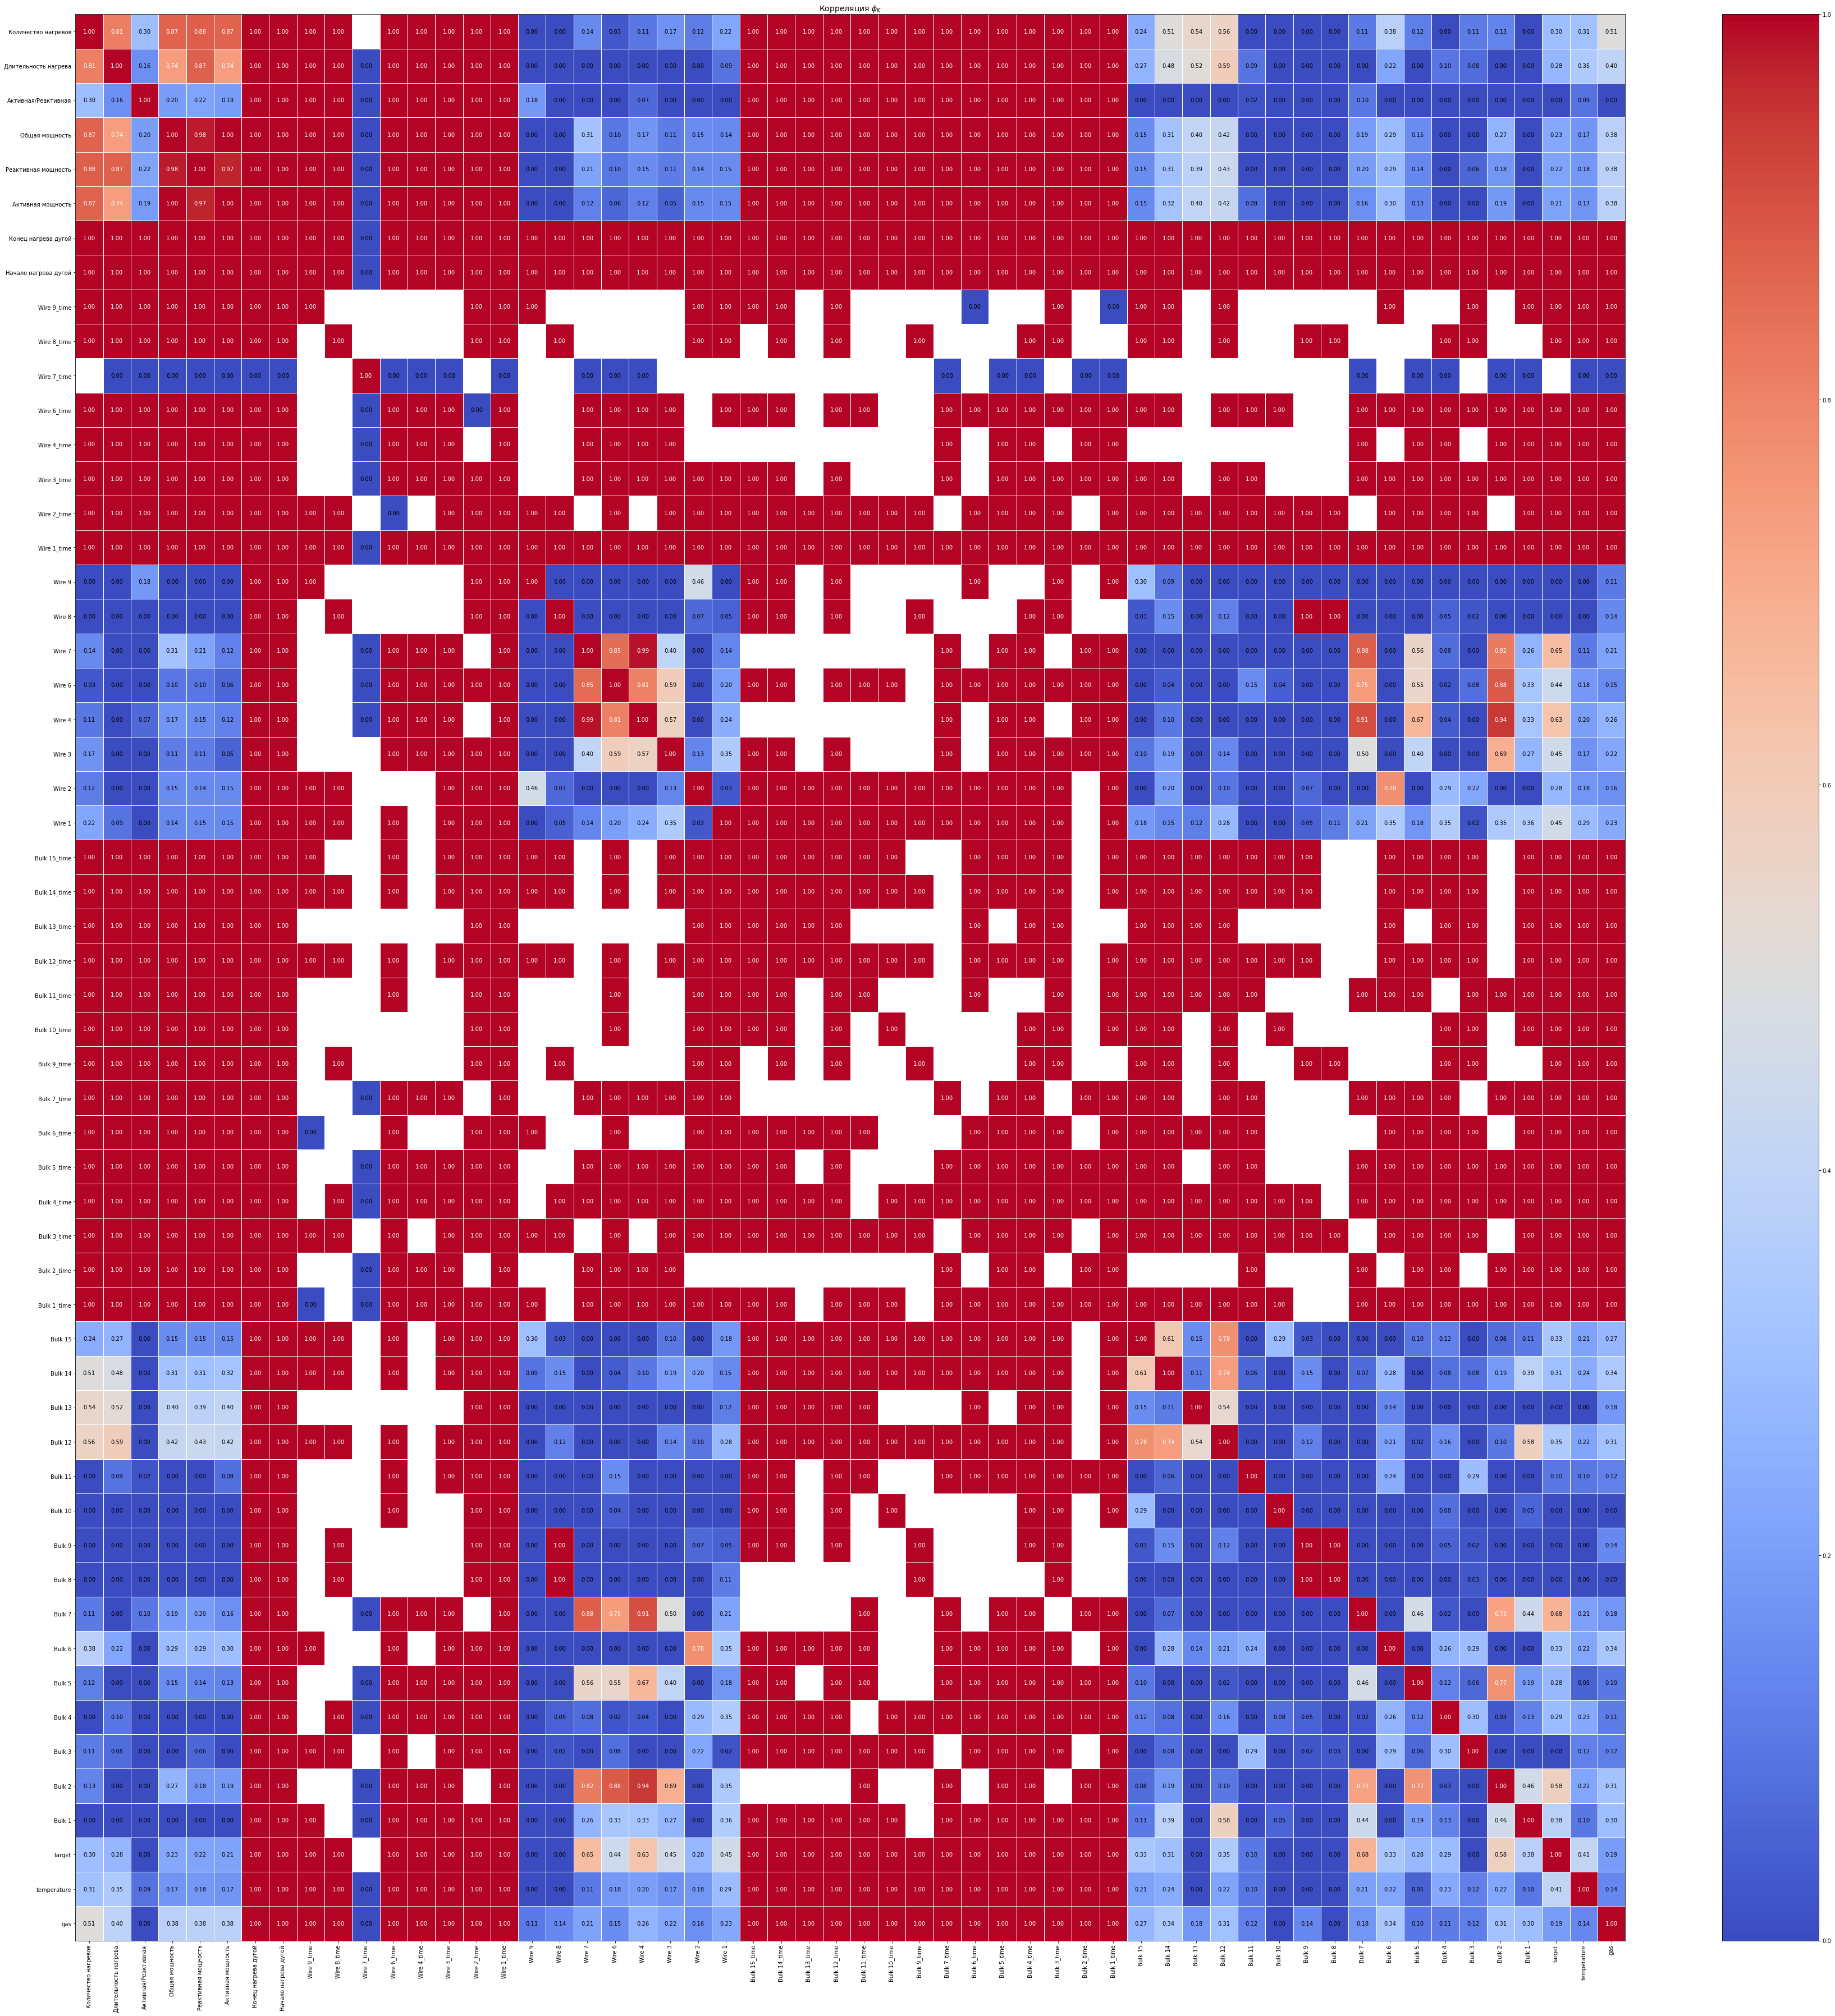

In [133]:
plot_correlation_matrix(phik_matrix.values, x_labels=phik_matrix.columns, y_labels=phik_matrix.index,
                        vmin=0, vmax=1, color_map='coolwarm', title='Корреляция $\phi_K$', fontsize_factor=1,
                        figsize=(50, 50))
plt.tight_layout()

Множество признаков имеют мультиколлиенарность, а именно все признаки связанные с датой, поэтому удалим их.

In [132]:
columns_time = total_df.select_dtypes(include=['datetime']).columns.to_list()

In [133]:
total_df = total_df.drop(columns=columns_time, axis=1)

И еще раз построим матрицу корреляции

In [136]:
# Расчитываем коэффициент корреляции Фи
phik_matrix = total_df.drop(columns=['key'], axis=1).phik_matrix(
    interval_cols=total_df.select_dtypes(include=['float', 'int']).columns.to_list())

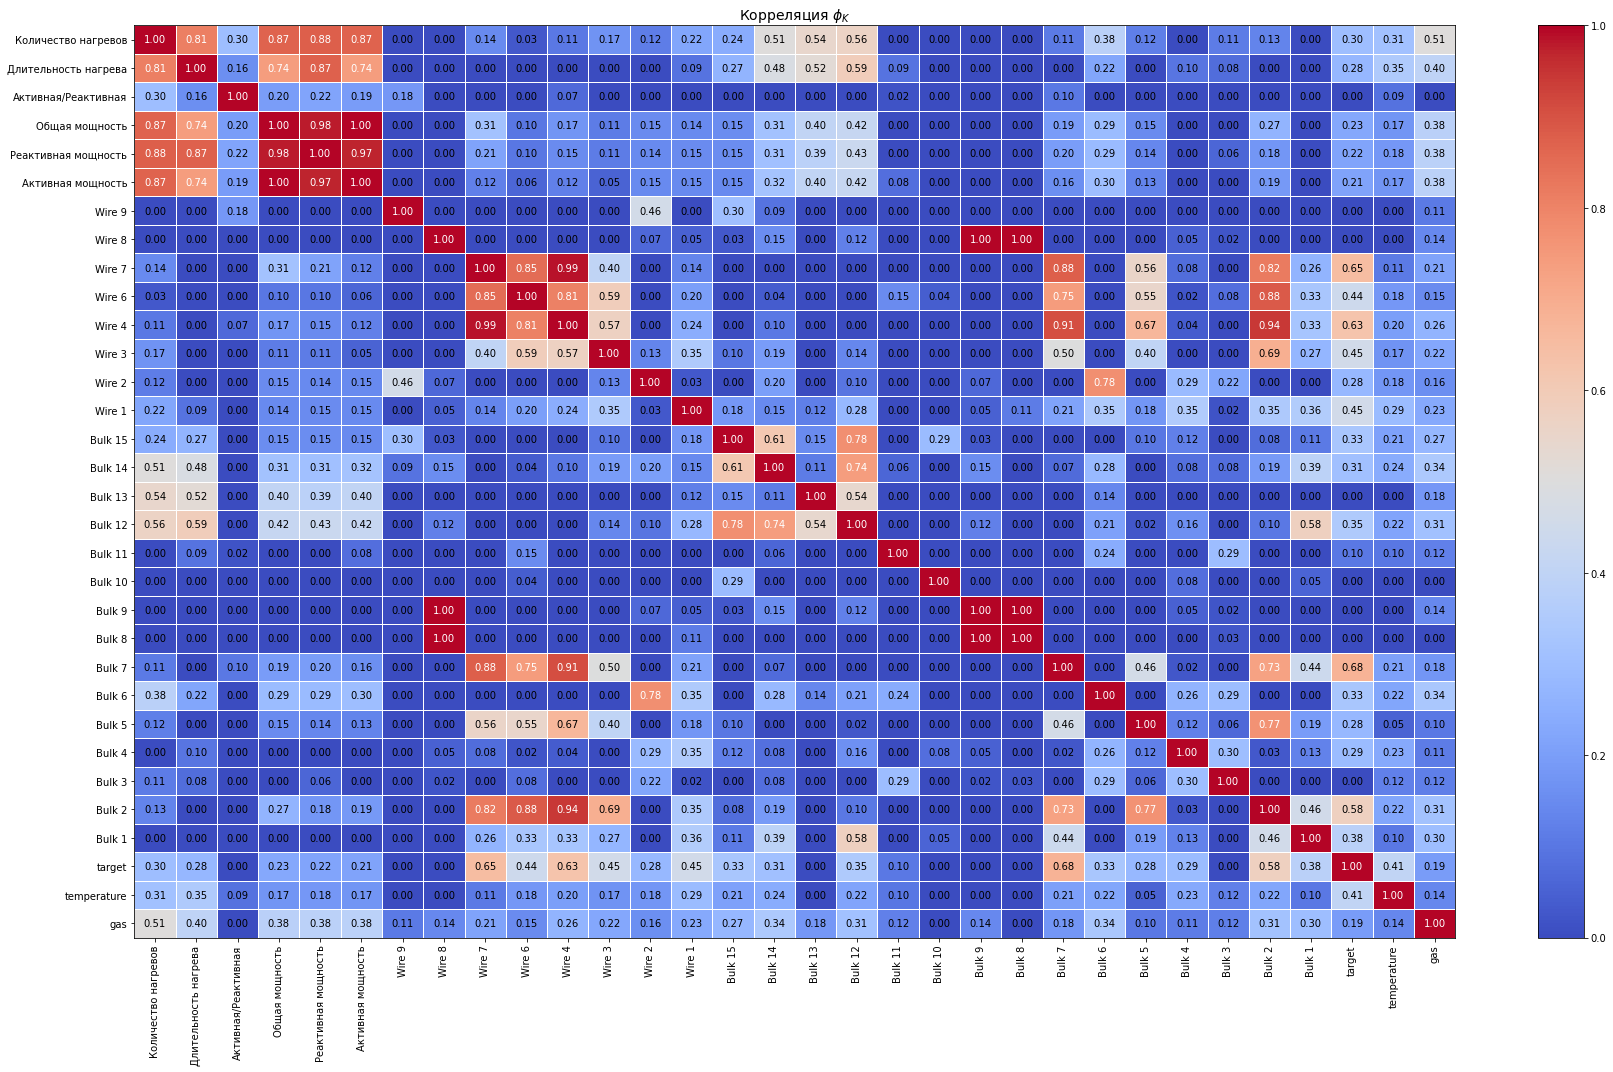

In [137]:
plot_correlation_matrix(phik_matrix.values, x_labels=phik_matrix.columns, y_labels=phik_matrix.index,
                        vmin=0, vmax=1, color_map='coolwarm', title='Корреляция $\phi_K$', fontsize_factor=1,
                        figsize=(25, 15))
plt.tight_layout()

Также есть мультикорреляция между `Bulk 9`, `Bulk 8` и `Wire 8`. Между `Активная мощность`, `Реактивная мощность` и `Общей мощностью`. Между `Wire 7` и `Wire 4`. Удалим все столбцы кроме `Общая мощность`, `Wire 7`. Также удалим столбцы `Bulk 11`, `Bulk 10`, так как они не делают никого вкалада.

In [134]:
total_df = total_df.drop(columns=['Bulk 9', 'Bulk 8', 'Bulk 10', 'Bulk 11', 'Wire 4',
                         'Wire 8', 'Активная мощность', 'Реактивная мощность'], axis=1)

In [139]:
# Расчитываем коэффициент корреляции Фи
phik_matrix = total_df.drop(columns=['key'], axis=1).phik_matrix(
    interval_cols=total_df.select_dtypes(include=['float', 'int']).columns.to_list())

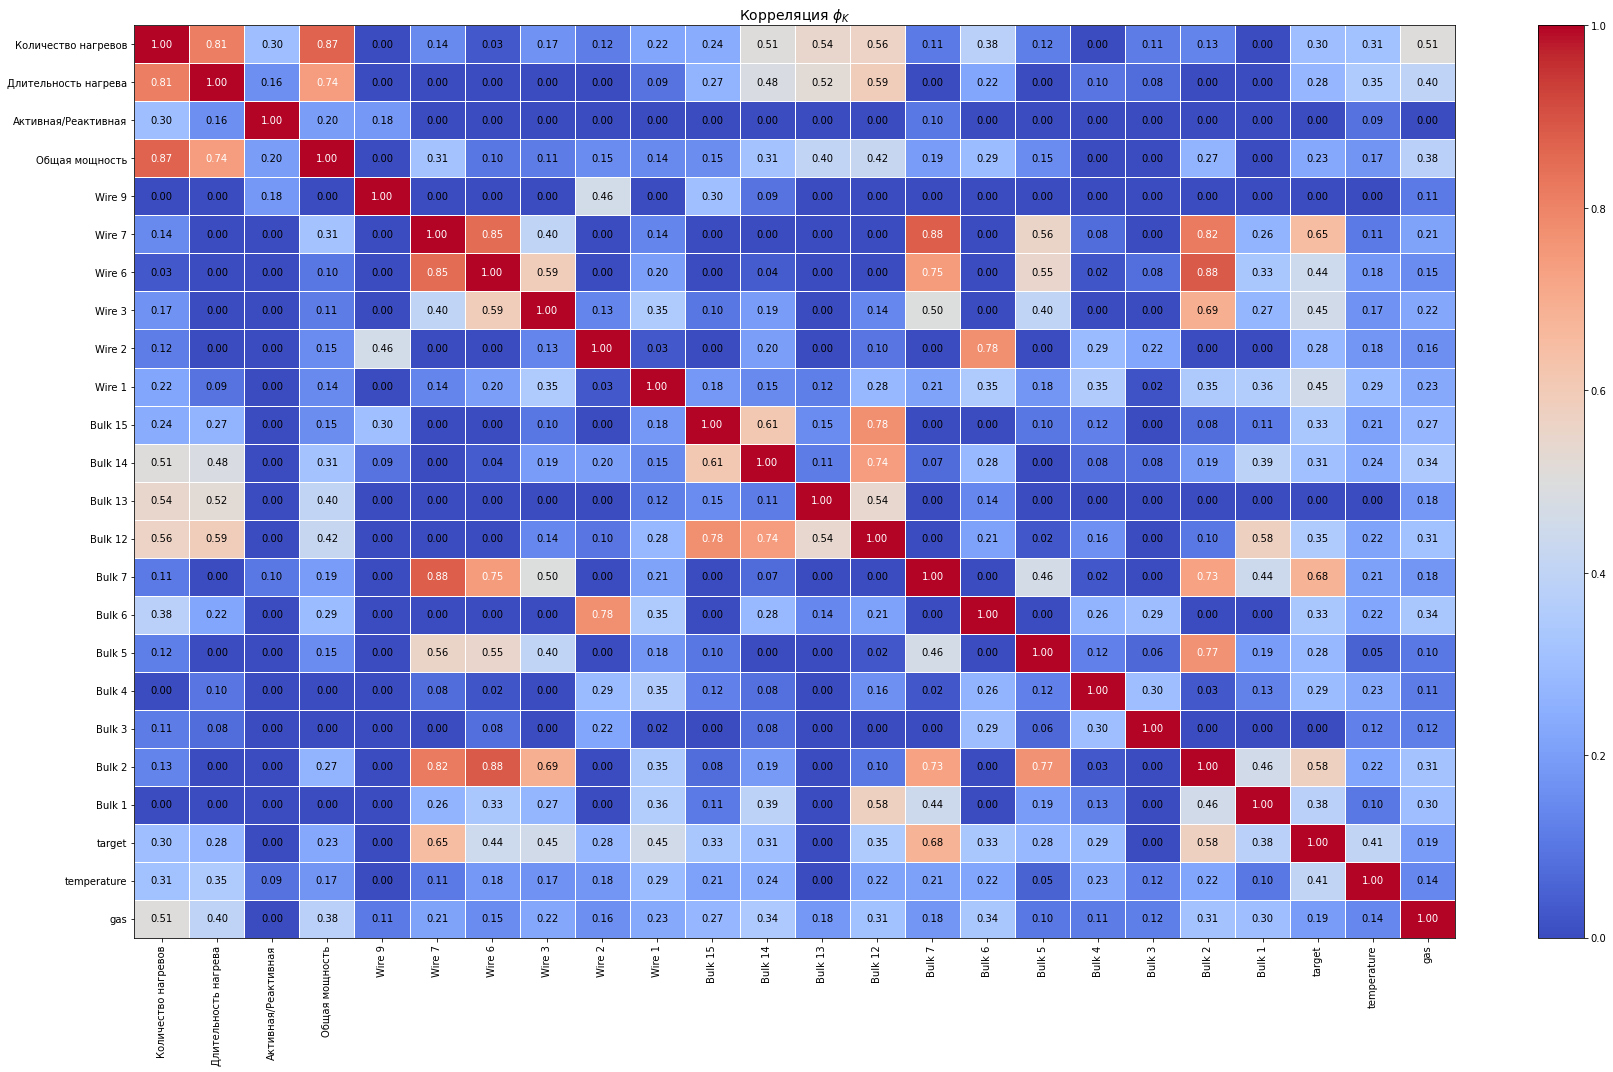

In [140]:
plot_correlation_matrix(phik_matrix.values, x_labels=phik_matrix.columns, y_labels=phik_matrix.index,
                        vmin=0, vmax=1, color_map='coolwarm', title='Корреляция $\phi_K$', fontsize_factor=1,
                        figsize=(25, 15))
plt.tight_layout()

В целом все остальные признаки выглядет полезными, возможно в дальнейшем придется удалить признаки связанные с мощностью (активная/реактиваная), так как он особо не влияют на часть данных. Мультиколлинеарность между признаки не наблюдается. Можем приступать к подготовке данных к обучению.

# Подготовка данных для обучения

В планах для данной задачи использовать дерево решений, градиентный бустинг и полносвязную сетку. Для дерева не важно какие данные подаются на вход, а вот для сетки желательно их стандартизировать и для этого будем использовать `StandardScaler`.

In [135]:
# Отделяем таргет
X = total_df.drop(columns=['target', 'key'], axis=1)
y = total_df['target']

In [136]:
# Разбиваем данные на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=RANDOM_STATE,
    test_size=TEST_SIZE
)

In [137]:
# Инициализируем класс
scaler = StandardScaler()

In [138]:
# Масштабируем признаки
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Проверим размерность выборок

In [140]:
X_train_scaled.shape, y_train.shape

((1740, 24), (1740,))

In [144]:
X_test_scaled.shape, y_test.shape

((581, 24), (581,))

Можем приступать к обучению

# Обучение моделей

Перед нами стоит задача регрессии. Необходимо научится предсказывать температуру.Сравнивать модели будем по `MAE`. Обучать будем:
- Решающее дерево
- Случайный лес
- Градиентный бустинг
- Полносвязная сетка

Сначала обучим модели без подбора гиперпараметров. Выберем из них лучшее и уже для лучшей будем подбирать гиперпараметры.

## Базовая модель

За базовую модель возьмем дамми модель

In [145]:
model = DummyRegressor(strategy='mean')

metric = cross_val_score(model, X_train_scaled, y_train,
                         cv=5, scoring='neg_mean_absolute_error')

print(f'Среднее значение: {metric.mean():.2f}')
print(f'Стандартное отклонение: +-{metric.std():.2f}')

Среднее значение: -8.04
Стандартное отклонение: +-0.25


## Обучение классификаторов

In [146]:
# Создаем список моделей
algs = [
    ['Решающее дерево', DecisionTreeRegressor(random_state=RANDOM_STATE)],
    ['Градиентный бустинг', LGBMRegressor(random_state=RANDOM_STATE, verbosity=-1)],
    ['Случайный лес', RandomForestRegressor(random_state=RANDOM_STATE)]
]

In [147]:
for alg_name, model in tqdm(algs):
    metric = cross_val_score(model, X_train_scaled,
                             y_train, cv=5, scoring='neg_mean_absolute_error')
    print(f'{alg_name}')
    print(
        f'Среднее значение MAE: {metric.mean():.2f}, стандартное отклонение: +-{metric.std():.2f}')
    print(sep='')

  0%|          | 0/3 [00:00<?, ?it/s]

Решающее дерево
Среднее значение MAE: -8.41, стандартное отклонение: +-0.33

Градиентный бустинг
Среднее значение MAE: -6.27, стандартное отклонение: +-0.22

Случайный лес
Среднее значение MAE: -6.10, стандартное отклонение: +-0.27



Cлучайный лес и бустинг работают практически одинаково. Решающее дерево работает хуже базовой модели.

## Глубокое обучение

Будем обучать полносвязную нейронную сеть с двумя скрытыми слоями. Будем использовать Kfold для кросс-валидации. В качестве функции потерь используем MSE, для ускорения расчетов. Также в качестве регуляризации используем dropout.

In [152]:
# Класс архетиктуры нейронной сети
class NeuralNet(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, 
                 n_hidden_neurons_2, n_out_neurons, dropout_rate):
        super(NeuralNet, self).__init__()
    
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.dp1 = nn.Dropout(dropout_rate)
    
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.dp2 = nn.Dropout(dropout_rate)
    
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
    
    def forward(self, x):
        out = self.fc1(x)
        out = torch.relu(out)
        out = self.dp1(out)
        
        out = self.fc2(out)
        out = torch.relu(out)
        out = self.dp2(out)
        
        out = self.fc3(out)
        return out

In [149]:
# Переведем данные в тензор
X_train_ten = torch.FloatTensor(X_train_scaled)
y_train_ten = torch.FloatTensor(y_train.values)

In [150]:
# Задаем параметры нейронной сети
n_in_neurons = 24
n_hidden_neurons_1 = 32
n_hidden_neurons_2 = 16
n_out_neurons = 1
learning_rate = 0.01
num_epochs = 10000
n_splits = 5
dropout_rate = 0.4

In [154]:
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
fold_mae_scores = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train_ten)):
    
    # Разделение данных
    X_train_fold, X_val_fold = X_train_ten[train_idx], X_train_ten[val_idx]
    y_train_fold, y_val_fold = y_train_ten[train_idx], y_train_ten[val_idx]
        
    model = NeuralNet(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, 
                      n_out_neurons, dropout_rate)  # Вызываем класс
        
    loss = nn.MSELoss()  # В качестве функции потерь используем MSE
    # Создаем Adam оптимизатор
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    reduce = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.15, 
                                                        patience=25, min_lr=1e-6)
        
    # Цикл обучения
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()  # Обнуление градиентов

        preds = model.forward(X_train_fold).flatten()  # Прямое распространение
            
        loss_value = loss(preds, y_train_fold)
        loss_value.backward()
        optimizer.step()
            
        model.eval()
        with torch.no_grad():
            val_preds = model.forward(X_val_fold)
            mae = torch.mean(abs(val_preds - y_val_fold))
            val_loss = loss(val_preds, y_val_fold)
            neg_mae = -mae
            fold_mae_scores.append(neg_mae)
            
            # Вызываем step для ReduceLROnPlateau
            reduce.step(val_loss)
                
# Среднее значение MAE по всем фолдам
avg_mae = np.mean(fold_mae_scores)
print(f"Среднее значение MAE для {n_splits}-фолдовой кросс-валидации: {avg_mae:.2f}")
print(f"Стандартное отклонение MAE для {n_splits}-фолдовой кросс-валидации: +-{np.std(fold_mae_scores):.2f}")

Среднее значение MAE для 5-фолдовой кросс-валидации: -167.92
Стандартное отклонение MAE для 5-фолдовой кросс-валидации: +-108.88


Результат хуже, чем у базовой модели. Скорее всего из-за того, что не так много наблюдений. Сравним все модели между собой. Результат сведем в таблицу

| Модель | Срднее negMAE | Отклонение MAE | Лучше базовой модели? |
|:-------| :------: | :-------: | :-------: |
|**Дерево решений**| -8.41 | +-0.33 | ❌ |
|**Случайный лес**| -6.10 | +-0.27 | ✅ |
|**Градиентные бустинг**| -6.27 | +- 0.22 | ✅ |
|**Полносвязная сетка**| -167.92 | +-108.88 | ❌ |

По итогу выбор состоит из двух моделей. Случайный лес и бустинг в целом выдают одинаковый результат. Среднее значение меньше у леса, но у него больше отклонение, чем у бустинга. Также лес обучается дольше, чем бустинг, поэтому мой выбор в пользу бустинга.

## Подбор гиперпараметров

Так как наблюдений немного и бустинг обучается быстро, то для подбора параметров будем использовать `GridSearchCV`. Подбирать будем следующие параметры:
- num_leaves
- n_estimators
- max_depth
- learning_rate

In [155]:
# Инициализируем модель
lgbm = LGBMRegressor(random_state=RANDOM_STATE,
                    n_jobs=-1,
                    verbosity=-1)

In [156]:
# Создаём словарь со значениями гиперпараметров для перебора
parameters_lgbm = {
    'num_leaves': [31, 50, 100, 150, 200],
    'n_estimators': [100, 600, 1200],
    'max_depth': range(2, 8),
    'learning_rate': [0.001, 0.01]
}

In [157]:
gs_lgbm = GridSearchCV(
    lgbm,
    parameters_lgbm,
    cv=5,
    n_jobs=-1,
    scoring='neg_mean_absolute_error'
)

In [158]:
gs_lgbm.fit(X_train_scaled, y_train)

GridSearchCV(cv=5,
             estimator=LGBMRegressor(n_jobs=-1, random_state=111124,
                                     verbosity=-1),
             n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01],
                         'max_depth': range(2, 8),
                         'n_estimators': [100, 600, 1200],
                         'num_leaves': [31, 50, 100, 150, 200]},
             scoring='neg_mean_absolute_error')

In [159]:
print('Лучшая модель и её параметры:\n\n', gs_lgbm.best_estimator_)

print(f'Метрика MAE на кросс-валидации: {gs_lgbm.best_score_:.2f}')

print(f'Отклонение метрики на кросс-валидации: \
{pd.DataFrame(gs_lgbm.cv_results_)["std_test_score"].mean():.2f}')

Лучшая модель и её параметры:

 LGBMRegressor(learning_rate=0.01, max_depth=6, n_estimators=600, n_jobs=-1,
              random_state=111124, verbosity=-1)
Метрика MAE на кросс-валидации: -6.07
Отклонение метрики на кросс-валидации: 0.23


## Тестирование модели

Проверим качество лучшей модели на тестовой выборке. Значение метрики MAE должно быть менее 6.8.

In [160]:
y_pred = gs_lgbm.predict(X_test_scaled)

print(f'Метрика MAE на тесте: {-mean_absolute_error(y_test, y_pred):.2f}')
print(f'R2 на тесте {r2_score(y_test, y_pred):.2f}')

Метрика MAE на тесте: -6.34
R2 на тесте 0.34


In [161]:
# Оценим базовую модель на тесте
model = DummyRegressor(strategy='mean')

model.fit(X_train_scaled, y_train)

y_pred_dum = model.predict(X_test_scaled)

print(f'Метрика MAE на тесте: {-mean_absolute_error(y_test, y_pred_dum):.2f}')
print(f'R2 на тесте {r2_score(y_test, y_pred_dum):.2f}')

Метрика MAE на тесте: -7.94
R2 на тесте -0.01


Наша лучшая модель показывает лучше результаты, чем базовая по двум метрикам MAE И R2. Также мы получили метрику MAE меньше 6.8. что удовлетворяет условиям.

Посмотрим какие признаки наша модель считает самыми важными.

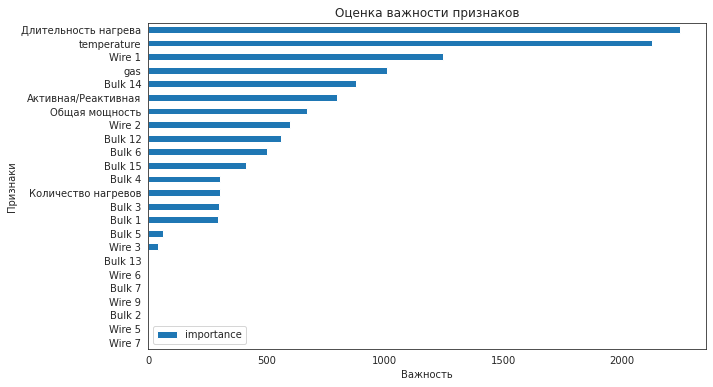

In [162]:
coefficients = gs_lgbm.best_estimator_.feature_importances_

sns.set_style('white')
feature_importance = pd.DataFrame({'feature': X_train.columns,
                                  'importance': np.abs(coefficients)})

feature_importance = (
    feature_importance.sort_values(by='importance', ascending=True)
)

feature_importance.plot(x='feature', y='importance', kind='barh', figsize=(10, 6))

plt.title('Оценка важности признаков')
plt.xlabel('Важность')
plt.ylabel('Признаки')

plt.show()

Можно выделить отметить самые важные признаки:
- Длительность нагрева
- Начальная температура
- Wire 1
- gas
- Bulk 14

В целом результаты логичные, что от начальной температуры и от того насколько долго будет длиться нагрев будет зависеть конечная температура. Среди материалов самыми важными стали те признаки, которые чаще использовались (у двух этих столбцов было меньше всего пропущенных значений, а `gas` использовался всегда.

Наименнее важными признаками являются:
- Bulk 13
- Wire 6
- Bulk 7
- Wire 9
- Bulk 2
- Wire 5
- Wire 2

Что можно объяснить тем, что данные материалы реже всего использовались.

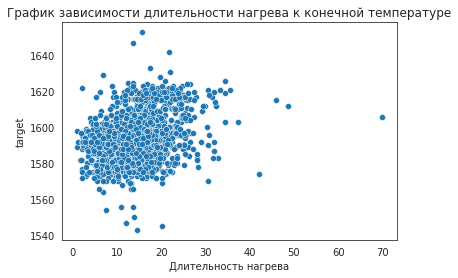

In [163]:
sns.scatterplot(data=total_df, x='Длительность нагрева', y='target')
plt.title('График зависимости длительности нагрева к конечной температуре')
plt.show()

В основном значения находятся в пределах от 1560 до 1630 по температуре и от 0 до 35 по длительности. Между данными признаками зависимость нелинейная.

# Вывод

Данные были получены из БД. 

Исследование проходило в 7 этапов:

1. Изучение данных
2. Исследовательский анализ данных и предобработка данных
3. Объединение таблиц
4. Исследовательский анализ итоговой таблицы
5. Корреляционный анализ
6. Обучение моеделей
7. Вывод

**1. Изучение данных**

Первым делом проверили количество таблиц с документацией к БД. Было обнаружено несколько таблиц, которые не описаны в документации, но исходя из их названия сделали вывод, что они никак не помогут для решения задачи. Далее проверили все ли таблицы имеют набор данных. В результате получили, что во всех таблицах есть данные.

- Таблица data_arc содержит 14876 записей.
- Таблица data_bulk содержит 3129 записей.
- Таблица data_bulk_time содержит 3129 записей.
- Таблица data_gas содержит 3239 записей.
- Таблица data_temp содержит 18092 записей.
- Таблица data_wire содержит 3081 записей.
- Таблица data_wire_time содержит 3081 записей.

**2. Исследовательский анализ данных и предобработка данных**

Провели анализ каждой из таблиц.

В таблице `data_arc` не было ни одного пропуска и дубликата, но были неправильные типы данных у двух столбцов. Перевели их в тип `datetime`. Также в столбце `Рекативная мощность` было найдено аномальное значение, которое мы удалили. Все данные распределены ненормально. Также сгенерировали новые признаки: длительность нагрева, общую мощность, соотношение активной мощности к реактивной, количество запуска нагрева электродами, общую реактивную мощность и общая активная мощность.

В таблице `data_bulk` в большинстве признаков были пропущенные значение. Мы их заполнили, так как пропуск означал, что материал не подавался. Перевели все столбцы в тип данных `float`. В столбцах `Bulk 12` и `Bulk 14` было найдено по одному аномальному значению, которые были удалены. Все данные распределены ненормально.

В таблице `data_bulk_time` было много пропущенных значений, так как она связана с предыдущей. Удалять мы их не стали. Перевели столбцы в формат `datetime`. Временные метки находятся в диапазоне от мая до сентября 2019 года, без явных выбросов или аномальных значений (например, нет дней или недельных интервалов между подачами материалов). Среднее время между подачей материалов в большинстве случаев составляет меньше 24 часов. Отклонения от среднего значения минимальны, что предполагает стабильный процесс.

В таблице `data_gas` не было ни одного пропущенного значения и дубликата. Были найдены несколько аномальных значений, которые мы удалили. Данные в данном датафрейме имеют ненормальное распределение

В таблице `data_temp` в одном столбце были найдены пропуски. Дубликатов не обнаружили. Перевели столбцы в нужный тип данных. Удалили аномальные значения исходя из условия заказчика (<1500 - это аномалия). Также нас интересовали партии, в которых были данные о начальной температуре и конечной. Конечная температура — наш таргет. Все данные распределены ненормально

В таблице `data_wire` много пропущенных значений и нет дубликатов. Заполнили пропуски по аналогии с `data_bulk`. Перевели столбцы в нужный тип данных. Также в столбце `Wire 1` удалили аномальные значения. Данные имеют ненормальное распределение.

В таблице `data_wire_temp` также много пропущенных значений по аналогии с предыдущей таблицей. Их также не стали удалять, так как это означало, что данный материал не подавался. Перевели данный в нужный формат. Временные метки находятся в диапазоне от мая до сентября 2019 года, без явных выбросов или аномальных значений (например, нет дней или недельных интервалов между подачами материалов). Среднее время между подачей материалов в большинстве случаев составляет меньше 24 часов. Отклонения от среднего значения минимальны, что предполагает стабильный процесс.

**3. Обьединение таблицы**

Обьединили таблицы так, чтобы каждой партии должно соответствовать одно наблюдение. В результате получили таблицу с 60 признаками и 2321 наблюдений.

**4. Исследовательский анализ итогового датафрейма**

Так как большинство признаков уже были проанализированы ранее. В данном разделе анализировали только новые столбцы и столбцы, которые сильно уменьшились после объединения: `Общая мощность`, `Активная/Реактивная`, `Количество нагревов`, `Длительность нагрева`, `Активная мощность`, `Реактивная мощность`, `Начало нагрева дугой` и `Конец нагрева дугой`.

Столбцу `Длительность нагрева` поменяли тип данных с timedelta на float и перевели значения в минуты. В результате анализа каких-то аномальных значений найдено не было, но взяли себе на заметку одно наблюдение в столбце `Длительность нагрева`. Построили гистограммы распределений и убедились визуально и статистически, что данные распределены ненормально. Сделали предположение, что данное количество признаков сократиться (60), так как часть из них должна коррелировать между собой, а некоторые не несут в себе никакой полезной информации.

**5. Корреляционный анализ**

Так как наши данные распределены ненормально, то для изучения взаимосвязи воспользовались коэффициентом корреляции $\phi_K$.

Множество временных признаков имели мультиколлинеарность и поэтому они были удалены. Далее еще раз рассчитали коэффициент корреляции и построили матрицу корреляций. Далее была обнаружена мультиколлинеарность между `Bulk 9`, `Bulk 8` и `Wire 8`. Между `Активная мощность`, `Реактивная мощность` и `Общей мощностью`. Между `Wire 7` и `Wire 4`. Удалили все столбцы кроме `Общая мощность`, `Wire 7`. А Также решили удалить столбцы `Bulk 11`, `Bulk 10`, так как они не давали никого вклада. После еще раз построили матрицу корреляции и убедились, что мультиколлинеарности между признаками нет, а также, что все остальные признаки несут в себе информацию. В результате у нас осталось 24 признака.

**6. Обучение моделей**

Перед нами стояла задача регрессии. Необходимо было научится предсказывать температуру. Сравнивали модели по MAE. Обучали сначала без подбора гиперпараметров, потом из них выбрали лучшую и уже для нее подбирали:

- Решающее дерево
- Случайный лес
- Градиентный бустинг
- Полносвязная сетка

Перед обучением масштабировали данные, так как для деревьев это неважно, то мы использовали `StandardScaller`, так как его лучше использовать для сетки.

За базовую модель взяли дамми модель. Результаты всех моделей свели в таблицу.

| Модель | Срднее negMAE | Отклонение MAE | Лучше базовой модели? |
|:-------| :------: | :-------: | :-------: |
|**Дерево решений**| -8.41 | +-0.33 | ❌ |
|**Случайный лес**| -6.10 | +-0.27 | ✅ |
|**Градиентные бустинг**| -6.27 | +- 0.22 | ✅ |
|**Полносвязная сетка**| -167.92 | +-108.88 | ❌ |

По итогу выбрали бустинг, так как он хоть и выдывал результат немного хуже, но у него меньше отклонение, а также он быстрее обучается. Так как наблюдений немного и бустинг обучается быстро, то для подбора параметров использовали `GridSearchCV`. Подбирали следующие параметры:
- num_leaves
- n_estimators
- max_depth
- learning_rate

В результате получили модель с параметрами learning_rate=0.01, max_depth=6, n_estimators=600. MAE: -6.07, Отклонение: +-0.23

Далее протестировали нашу модель и сравнили результаты на тесте с базовой моделью. Наша лучшая модель показывала лучше результаты, чем базовая по двум метрикам MAE И R2. Также мы получили метрику MAE меньше 6.8. что удовлетворяет условиям.

- Метрика MAE на тесте: -6.34
- R2 на тесте 0.34

Далее посмотрели какие признаки являются наиболее важными:
- Длительность нагрева
- Начальная температура
- Wire 1
- gas
- Bulk 14

В целом результаты логичные, что от начальной температуры и от того насколько долго будет длиться нагрев будет зависеть конечная температура. Среди материалов самыми важными стали те признаки, которые чаще использовались (у двух этих столбцов было меньше всего пропущенных значений, а `gas` использовался всегда.

Наименнее важными признаками являются:
- Bulk 13
- Wire 6
- Bulk 7
- Wire 9
- Bulk 2
- Wire 5
- Wire 2

Что можно объяснить тем, что данные материалы реже всего использовались.

И также в конце построили график зависимости между самым важным признаком и нашим таргетом. В результате увидели, что большая значения находятся в пределах от 1560 до 1630 по температуре и от 0 до 35 по длительности. Между данными признаками зависимость нелинейная.

**Вывод**

В результате смогли обучить модель, которая может предсказывать конечную температуру сплава. Лучшей моделью стал градиентный бустинг из библиотеки `LGBM`. Его параметры learning_rate=0.01, max_depth=6, n_estimators=600. Метрика MAE на тесте 6.34, что удовлетворяет условию заказчика. 

Результаты можно улучшить, если будет больше наблюдений, то в таком случае, возможно, будет уже лучше работать полносвязная нейронная сеть. В качестве рекомендаций следует обратить внимание на количество сыпучих материалов, которые будут использоваться для сплава они более важны, чем проволочные для итоговой температуры. Также возможно стоит увеличить количество нагревов, но при этом уменьшить мощность. В таком случаем будет тратиться меньше электроэнергии.